In [2]:
# 讀取資料 底下code好亂，大多數都沒寫註解可能有點難看
import pandas as pd

name = ["古亭","士林","大同","中山","松山","萬華","陽明"] # 七個測站中文名稱
eng_name = ["GUTIN","SHILIN","DATON","ZHONGSHAN","SONGSHANG","WANHUA","YANGMIN"] # 七個測站英文名稱
store_dict = {} # 建立空dict儲存不同測站&年份的資料
for i in range(len(name)): # 依照中文名稱讀取檔案
    for j in range(2013,2023): # 擷取所需年分
        if j in range(2013,2018): # 2013年~2017年資料讀取方式
            store_dict[f"{eng_name[i]}_{j}"] = pd.read_excel(r"C:\Users\Kevin\Desktop\Mypython\Final_Project\Taipei-air-quality\{}_{}.xls".format(name[i],j), sheet_name=0)
        elif j in range(2018,2023): # 2018年~2023年資料讀取方式
            store_dict[f"{eng_name[i]}_{j}"] = pd.read_csv(r"C:\Users\Kevin\Desktop\Mypython\Final_Project\Taipei-air-quality\{}_{}.csv".format(name[i],j),encoding="big5")
            store_dict[f"{eng_name[i]}_{j}"] = store_dict[f"{eng_name[i]}_{j}"].drop([0])

In [3]:
# 資料前處理

## 去除欄位數值前空格 & 欄位轉為字串型式

for key,value in store_dict.items(): 
    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        return x
    data = store_dict[key]
    data = data.map(strip_str)
    data.columns = data.columns.astype(str)
    data.rename(columns=lambda x: x.strip(), inplace=True)
    store_dict[key] = data
    

In [4]:
# 資料前處理

## 去除非計算所需欄位

for key1,value1 in store_dict.items():
    data1 = store_dict[key1]
    air_p = (
        (data1["測項"] == "NO2") | 
        (data1["測項"] == "O3") | 
        (data1["測項"] == "PM10") | 
        (data1["測項"] == "PM2.5") | 
        (data1["測項"] == "SO2") | 
        (data1["測項"] == "CO") |
        (data1["測項"] == "WIND_SPEED") |
        (data1["測項"] == "AMB_TEMP") |
        (data1["測項"] == "RAINFALL") 
        )
    store_dict[key1] = data1[air_p]
    store_dict[key1] = store_dict[key1].reset_index()

In [5]:
# 資料前處理

## 日期轉換

for key2,value2 in store_dict.items():
    DATE = []
    MONTH = []
    DAY = []
    MONTH_DAY = []
    YEAR = []
    for m in range(len(store_dict[key2])):
        DATE.append(store_dict[key2]["日期"][m][0:10])
        MONTH.append(store_dict[key2]["日期"][m][5:7])
        DAY.append(store_dict[key2]["日期"][m][8:10])
        MONTH_DAY.append(store_dict[key2]["日期"][m][5:10])
        YEAR.append(store_dict[key2]["日期"][m][0:4])
    store_dict[key2]["日期"] = DATE
    store_dict[key2]["月份"] = MONTH
    store_dict[key2]["日數"] = DAY
    store_dict[key2]["年分"] = YEAR
    store_dict[key2]["月份+日期"] = MONTH_DAY


In [6]:
# 計算CO前8小時濃度值轉換成AQI

import numpy as np

def CO_AQI_COUNT(DATA):
    CO_df = DATA[DATA["測項"] == "CO"].reset_index()
    CO_CON = [] # 前8個小時平均值 ppm
    TIME_list = CO_df.columns[4:28]
    Day_list = []
    for coo in range(len(CO_df)):
        Day_list.append(CO_df["日期"][coo])
        for coo_time in range(len(TIME_list)):
            null_list = []
            count_list = []
            if coo_time in range(8,24):
                for ee in range(0,8):
                    null_list.append(CO_df.loc[coo,"{}".format(TIME_list[coo_time-8]):"{}".format(TIME_list[coo_time-1])][ee])
            elif coo_time in range(0,8):
                if coo != 0:
                    for ii in range(0,coo_time-1):
                        null_list.append(CO_df.loc[coo,"00":"{}".format(TIME_list[coo_time-1])][ii])
                    for jj in range(0,8-coo_time):
                        null_list.append(CO_df.loc[coo-1,"{}".format(TIME_list[23+coo_time-8]):"23"][jj])
                else:
                    null_list.append(np.nan)
            for xx in range(len(null_list)):
                try:
                    count_list.append(float(null_list[xx]))
                except:
                    count_list.append(np.nan)
            CO_non_nan_count = np.count_nonzero(~np.isnan(count_list))
            CO_CON.append(np.nansum(count_list)/CO_non_nan_count)
    CO_AQI = []
    for a1 in range(len(CO_CON)):
        if np.isnan(CO_CON[a1]) == True:
            CO_AQI.append(np.nan)
        elif 0 <= CO_CON[a1] < 4.5:
            CO_AQI.append(CO_CON[a1]*50/4.5)
        elif 4.5 <= CO_CON[a1] <= 9.5:
            CO_AQI.append(50+(CO_CON[a1]-4.5)*50/(9.5-4.5))
        elif 9.5 <= CO_CON[a1] <= 12.5:
            CO_AQI.append(100+(CO_CON[a1]-9.5)*50/(12.5-9.5))
        elif 12.5 <= CO_CON[a1] <= 15.5:
            CO_AQI.append(150+(CO_CON[a1]-12.5)*50/(15.5-12.5))
        elif 15.5 <= CO_CON[a1] <= 30.5:
            CO_AQI.append(200+(CO_CON[a1]-15.5)*100/(30.5-15.5))
        elif 30.5 <= CO_CON[a1] <= 40.5:
            CO_AQI.append(300+(CO_CON[a1]-30.5)*100/(40.5-30.5))
        elif 40.5 <= CO_CON[a1] <= 50.5:
            CO_AQI.append(400+(CO_CON[a1]-40.5)*100/(50.5-40.5))
    CO_CON1 = []
    CO_CON2 = []
    for a6 in range(len(CO_AQI)):
        if a6%24 != 23:
            CO_CON2.append(CO_AQI[a6])
        elif a6%24 == 23:
            CO_CON2.append(CO_AQI[a6])
            CO_CON1.append(CO_CON2)
            CO_CON2 = []
    CO_AQI1 = {}
    for a7 in range(len(CO_CON1)):
        CO_AQI1[Day_list[a7]] = CO_CON1[a7]
    return CO_AQI1

In [7]:
# 計算SO2每小時濃度值轉換AQI，若計算後AQI值超過150則要替換成SO2的前24小時濃度平均值(只不過不一定會超過這個值就是了)

def SO2_AQI_COUNT(DATA):
    SO2_df = DATA[DATA["測項"] == "SO2"].reset_index(drop=True)
    SO2_CON = []
    Date_list = []
    SO2_24_CON = []
    Time_list = SO2_df.columns[4:28]
    for a3 in range(len(SO2_df)):
        Date_list.append(SO2_df["日期"][a3])
        for SO2_time in range(len(Time_list)):
            try:
                SO2_CON.append(float(SO2_df.loc[a3,"{}".format(Time_list[SO2_time])]))
            except:
                SO2_CON.append(np.nan)
    for b6 in range(len(SO2_df)):
        for SO2__time in range(len(Time_list)):
            store_list = []
            store_list1 = []
            if SO2__time == 0:
                if b6 != 0:
                    for c2 in range(0,24):
                        store_list.append(SO2_df.loc[b6-1,"00":"23"][c2])
                elif b6 == 0:
                    store_list.append(np.nan)
            elif SO2__time in range(1,24):
                if b6 != 0:
                    for b7 in range(0,SO2__time):
                        store_list.append(SO2_df.loc[b6,"00":"{}".format(Time_list[SO2__time])][b7])
                    for b8 in range(0,24-SO2__time):
                        store_list.append(SO2_df.loc[b6-1,"{}".format(Time_list[SO2__time-1]):"23"][b8])
                elif b6 == 0:
                    store_list.append(np.nan)
            for b9 in range(len(store_list)):
                try:
                    store_list1.append(float(store_list[b9]))
                except:
                    store_list1.append(np.nan)
            SO2_non_nan_count = np.count_nonzero(~np.isnan(store_list1))
            SO2_24_CON.append(np.nansum(store_list1)/SO2_non_nan_count)

    SO2_AQI = []
    for a8 in range(len(SO2_CON)):
        if np.isnan(SO2_CON[a8]) == True:
            SO2_AQI.append(np.nan)
        elif 0 <= SO2_CON[a8] < 20:
            SO2_AQI.append(SO2_CON[a8]*50/20)
        elif 20 <= SO2_CON[a8] < 75:
            SO2_AQI.append(50+(SO2_CON[a8]-20)*50/(75-20))
        elif 75 <= SO2_CON[a8] < 185:
            SO2_AQI.append(100+(SO2_CON[a8]-75)*50/(185-75))
        elif 185 <= SO2_CON[a8] < 305:
            SO2_AQI.append(150+(SO2_24_CON[a8]-185)*50/(305-185))
        elif 305 <= SO2_CON[a8] < 605:
            SO2_AQI.append(200+(SO2_24_CON[a8]-305)*100/(605-305))
        elif 605 <= SO2_CON[a8] < 805:
            SO2_AQI.append(300+(SO2_24_CON[a8]-605)*100/(805-605))
        elif 805 <= SO2_CON[a8] < 1005:
            SO2_AQI.append(400+(SO2_24_CON[a8]-805)*100/(1005-805))
    SO2_AQI1 = [] 
    SO2_AQI2 = []
    for a9 in range(len(SO2_AQI)):
        if a9%24 != 23:
            SO2_AQI1.append(SO2_AQI[a9])
        elif a9%24 == 23:
            SO2_AQI1.append(SO2_AQI[a9])
            SO2_AQI2.append(SO2_AQI1)
            SO2_AQI1 = []
    SO2_AQI3 = {}
    for b2 in  range(len(SO2_AQI2)):
        SO2_AQI3[Date_list[b2]] = SO2_AQI2[b2]
    return SO2_AQI3

In [8]:
# 計算NO2即時濃度值轉換AQI

def NO2_AQI_COUNT(DATA):
    NO2_df = DATA[DATA["測項"]=="NO2"].reset_index(drop=True)
    NO2_CON = []
    NO2_CON_24 = []
    Date__list = []
    Time__list = NO2_df.columns[4:28]
    for a3 in range(len(NO2_df)):
        Date__list.append(NO2_df["日期"][a3])
        for SO2_time in range(len(Time__list)):
            try:
                NO2_CON.append(float(NO2_df.loc[a3,"{}".format(Time__list[SO2_time])]))
            except:
                NO2_CON.append(np.nan)
    NO2_AQI = []
    for b3 in range(len(NO2_CON)):
        if 0 <= NO2_CON[b3] < 30:
            NO2_AQI.append(NO2_CON[b3]*50/30)
        elif 30 <= NO2_CON[b3] < 100:
            NO2_AQI.append(50+(NO2_CON[b3]-30)*50/(100-30))
        elif 100 <= NO2_CON[b3] < 360:
            NO2_AQI.append(100+(NO2_CON[b3]-100)*50/(360-100))
        elif 360 <= NO2_CON[b3] < 650:
            NO2_AQI.append(150+(NO2_CON[b3]-360)*50/(650-360))
        elif 650 <= NO2_CON[b3] < 1250:
            NO2_AQI.append(200+(NO2_CON[b3]-650)*100/(1250-650))
        elif 1250 <= NO2_CON[b3] < 1650:
            NO2_AQI.append(300+(NO2_CON[b3]-1250)*100/(1650-1250))
        elif 1650 <= NO2_CON[b3] < 2050:
            NO2_AQI.append(400+(NO2_CON[b3]-1650)*100/(2050-1650))
        elif np.isnan(NO2_CON[b3]) == True:
            NO2_AQI.append(np.nan)
    NO2_AQI1 = []
    NO2_AQI2 = []
    for b4 in range(len(NO2_AQI)):
        if b4%24 != 23:
            NO2_AQI1.append(NO2_AQI[b4])
        elif b4%24 == 23:
            NO2_AQI1.append(NO2_AQI[b4])
            NO2_AQI2.append(NO2_AQI1)
            NO2_AQI1 = []
    NO2_AQI3 = {}
    for b5 in range(len(NO2_AQI2)):
        NO2_AQI3[Date__list[b5]] = NO2_AQI2[b5]
    return NO2_AQI3

In [9]:
def PM25_AQI_COUNT(DATA):
    PM25_df = DATA[DATA["測項"] == "PM2.5"].reset_index() 
    PM25_CON1 = [] # 0.5 * 前12小時平均值 + 0.5 * 前4小時平均值 (四捨五入到小數點第一位) (必須前4小時2筆有效 & 前12小時6筆有效)
    PM25_CON2 = []
    PM25_CON3 = []
    PM25_AQI1 = []
    Date___list = []
    Time___list = PM25_df.columns[4:28]
    for c3 in range(len(PM25_df)):
        Date___list.append(PM25_df["日期"][c3])
        for PM25_time in range(len(Time___list)):
            PM25_CON = []
            if PM25_time in range(1,12):
                if c3 == 0:
                    PM25_CON.append(np.nan)
                elif c3 != 0:
                    for c5 in range(0,12-PM25_time):
                        PM25_CON.append(PM25_df.loc[c3-1,"{}".format(Time___list[PM25_time+12]):"23"][c5])
                    for c4 in range(0,PM25_time-1):
                        PM25_CON.append(PM25_df.loc[c3,"00":"{}".format(Time___list[PM25_time-1])][c4])
            elif PM25_time in range(12,24):
                for c6 in range(0,12):
                    PM25_CON.append(PM25_df.loc[c3,"{}".format(Time___list[PM25_time-11]):"{}".format(Time___list[PM25_time])][c6])
            elif PM25_time == 0:
                if c3 != 0:
                    for d4 in range(0,12):
                        PM25_CON.append(PM25_df.loc[c3-1,"12":"23"][d4])
                elif c3 == 0:
                    PM25_CON.append(np.nan)
            PM25_CON1.append(PM25_CON)
    for c7 in range(len(PM25_CON1)):
        if len(PM25_CON1[c7]) > 1:
            Four_hour = PM25_CON1[c7][-4:]
            if pd.isnull(PM25_CON1[c7]).sum() > 6:
                PM25_CON2.append(np.nan)
            elif pd.isnull(Four_hour).sum() > 2:
                PM25_CON2.append(np.nan)
            else:
                PM25_CON2.append(PM25_CON1[c7])
        else:
            PM25_CON2.append(np.nan)
    for c8 in range(len(PM25_CON2)):
        PM25_in = PM25_CON2[c8]
        summ = 0
        if type(PM25_in) != list:
            PM25_CON3.append(np.nan)
        else:
            lenn = len(PM25_in) - pd.isnull(PM25_in).sum()
            for d6 in range(len(PM25_in)):
                try:    
                    summ += float(PM25_in[d6])
                except:
                    summ += 0
            PM25_CON3.append(summ/lenn)
    for c9 in range(len(PM25_CON3)):
        if 0 <= PM25_CON3[c9] < 15.5:
             PM25_AQI1.append(PM25_CON3[c9]*50/15.5)
        elif 15.5 <= PM25_CON3[c9] < 35.5:
            PM25_AQI1.append(50+(PM25_CON3[c9]-15.5)*50/(35.5-15.5))
        elif 35.5 <= PM25_CON3[c9] < 54.5:
             PM25_AQI1.append(100+(PM25_CON3[c9]-35.5)*50/(54.5-35.5))
        elif 54.5 <= PM25_CON3[c9] < 150.5:
            PM25_AQI1.append(150+(PM25_CON3[c9]-54.5)*50/(150.5-54.5))
        elif 150.5 <= PM25_CON3[c9] < 250.5:
            PM25_AQI1.append(200+(PM25_CON3[c9]-150.5)*100/(250.5-150.5))
        elif 250.5 <= PM25_CON3[c9] < 350.5:
            PM25_AQI1.append(300+(PM25_CON3[c9]-250.5)*100/(350.5-250.5))
        elif 350.5 <= PM25_CON3[c9] < 500.5:
            PM25_AQI1.append(400+(PM25_CON3[c9]-350.5)*100/(500.5-350.5))
        elif np.isnan(PM25_CON3[c9]) == True:
            PM25_AQI1.append(np.nan)
    PM25_AQI2 = []
    PM25_AQI3 = []
    for d1 in range(len(PM25_AQI1)):
        if d1%24 != 23:
            PM25_AQI2.append(round(PM25_AQI1[d1],2))
        elif d1%24 == 23:
            PM25_AQI2.append(round(PM25_AQI1[d1],2))
            PM25_AQI3.append(PM25_AQI2)
            PM25_AQI2 = []
    PM25_AQI4 = {}
    for d2 in range(len(PM25_AQI3)):
        PM25_AQI4[Date___list[d2]] = PM25_AQI3[d2]
    return PM25_AQI4

In [10]:
# 計算PM10濃度轉換AQI

def PM10_AQI_COUNT(DATA):
    PM10_df = DATA[DATA["測項"] == "PM10"].reset_index(drop=True)
    PM10_CON1 = [] # 0.5 * 前12小時平均值 + 0.5 * 前4小時平均值 (四捨五入到小數點第一位) (必須前4小時2筆有效 & 前12小時6筆有效)
    PM10_CON2 = []
    PM10_CON3 = []
    PM10_AQI1 = []
    Date____list = []
    Time____list = PM10_df.columns[4:28]
    for d9 in range(len(PM10_df)):
        Date____list.append(PM10_df["日期"][d9])
        for PM10_time in range(len(Time____list)):
            PM10_CON = []
            if PM10_time in range(1,12):
                if d9 == 0:
                    PM10_CON.append(np.nan)
                elif d9 != 0:
                    for d7 in range(0,12-PM10_time):
                        PM10_CON.append(PM10_df.loc[d9-1,"{}".format(Time____list[PM10_time+12]):"23"][d7])
                    for d8 in range(0,PM10_time-1):
                        PM10_CON.append(PM10_df.loc[d9,"00":"{}".format(Time____list[PM10_time-1])][d8])
            elif PM10_time in range(12,24):
                for e1 in range(0,12):
                    PM10_CON.append(PM10_df.loc[d9,"{}".format(Time____list[PM10_time-11]):"{}".format(Time____list[PM10_time])][e1])
            elif PM10_time == 0:
                if d9 != 0:
                    for e7 in range(0,12):
                        PM10_CON.append(PM10_df.loc[d9-1,"12":"23"][e7])
                elif d9 == 0:
                    PM10_CON.append(np.nan)
            PM10_CON1.append(PM10_CON)
    for e2 in range(len(PM10_CON1)):
        if len(PM10_CON1[e2]) > 1:
            Four_hour = PM10_CON1[e2][-4:]
            if pd.isnull(PM10_CON1[e2]).sum() > 6:
                PM10_CON2.append(np.nan)
            elif pd.isnull(Four_hour).sum() > 2:
                PM10_CON2.append(np.nan)
            else:
                PM10_CON2.append(PM10_CON1[e2])
        else:
            PM10_CON2.append(np.nan)
    for e3 in range(len(PM10_CON2)):
        PM10_in = PM10_CON2[e3]
        Count___ = 0
        if type(PM10_in) != list:
            PM10_CON3.append(np.nan)
        else:
            lenn = len(PM10_in) - pd.isnull(PM10_in).sum()
            for e8 in range(len(PM10_in)):
                try: 
                    Count___ += float(PM10_in[e8])
                except:
                    Count___ += 0
            PM10_CON3.append(Count___/lenn)
    for e4 in range(len(PM10_CON3)):
        if 0 <= PM10_CON3[e4] < 50:
             PM10_AQI1.append(PM10_CON3[e4]*50/50)
        elif 50 <= PM10_CON3[e4] < 100:
            PM10_AQI1.append(50+(PM10_CON3[e4]-50)*50/(100-50))
        elif 100 <= PM10_CON3[e4] < 255:
             PM10_AQI1.append(100+(PM10_CON3[e4]-100)*50/(255-100))
        elif 255 <= PM10_CON3[e4] < 355:
            PM10_AQI1.append(150+(PM10_CON3[e4]-255)*50/(355-255))
        elif 355 <= PM10_CON3[e4] < 425:
            PM10_AQI1.append(200+(PM10_CON3[e4]-355)*100/(425-355))
        elif 425 <= PM10_CON3[e4] < 505:
            PM10_AQI1.append(300+(PM10_CON3[e4]-425)*100/(505-425))
        elif 505 <= PM10_CON3[e4] < 605:
            PM10_AQI1.append(400+(PM10_CON3[e4]-505)*100/(605-505))
        elif np.isnan(PM10_CON3[e4]) == True:
            PM10_AQI1.append(np.nan)
    PM10_AQI2 = []
    PM10_AQI3 = []
    for e5 in range(len(PM10_AQI1)):
        if e5%24 != 23:
            PM10_AQI2.append(round(PM10_AQI1[e5],1))
        elif e5%24 == 23:
            PM10_AQI2.append(round(PM10_AQI1[e5],1))
            PM10_AQI3.append(PM10_AQI2)
            PM10_AQI2 = []
    PM10_AQI4 = {}
    for e6 in range(len(PM10_AQI3)):
        PM10_AQI4[Date____list[e6]] = PM10_AQI3[e6]
    return PM10_AQI4


In [11]:
def O3_AQI_COUNT(DATA):
    O3_df = DATA[DATA["測項"] == "O3"].reset_index(drop=True)
    O3_CON = []
    DateList = []
    O3_8_CON = []
    TimeList = O3_df.columns[4:28]
    for f1 in range(len(O3_df)):
        DateList.append(O3_df["日期"][f1])
        for O3_time in range(len(TimeList)):
            N_List = []
            N_List1 = []
            try:
                O3_CON.append(float(O3_df.loc[f1,"{}".format(TimeList[O3_time])])/1000)
            except:
                O3_CON.append(np.nan)
            if O3_time in range(8,24):
                for zz in range(0,8):
                    N_List.append(O3_df.loc[f1,"{}".format(TimeList[O3_time-8]):"{}".format(TimeList[O3_time])][zz])
            elif O3_time in range(0,8):
                if f1 != 0:
                    for yy in range(0,O3_time):
                        N_List.append(O3_df.loc[f1,"00":"{}".format(TimeList[O3_time-1])][yy])
                    for ww in range(0,8-O3_time):
                        N_List.append(O3_df.loc[f1-1,"{}".format(TimeList[23+O3_time-8]):"23"][ww])
                else:
                    N_List.append(np.nan)
            for xx in range(len(N_List)):
                try:
                    N_List1.append(float(N_List[xx])/1000)
                except:
                    N_List1.append(np.nan)
            O3_non_nan_count = np.count_nonzero(~np.isnan(N_List1))
            O3_8_CON.append(np.nansum(N_List1)/O3_non_nan_count)
    O3_AQI = []
    for f9 in range(len(O3_CON)):
        if np.isnan(O3_8_CON[f9]) == True:
            O3_AQI.append(np.nan)
        elif 0 <= O3_8_CON[f9] < 0.054:
            O3_AQI.append(O3_8_CON[f9]*50/0.054)
        elif 0.054 <= O3_8_CON[f9] < 0.07:
            O3_AQI.append(50+(O3_8_CON[f9]-0.054)*50/(0.07-0.054))
        elif 0.07 <= O3_8_CON[f9] < 0.085:
            O3_AQI.append(100+(O3_8_CON[f9]-0.07)*50/(0.085-0.07))
        elif 0.085 <= O3_8_CON[f9] < 0.105:
            O3_AQI.append(150+(O3_8_CON[f9]-0.085)*50/(0.105-0.085))
        elif 0.105 <= O3_8_CON[f9] < 0.2:
            O3_AQI.append(200+(O3_8_CON[f9]-0.105)*100/(0.2-0.105))
        
    O3_AQI1 = []
    O3_AQI2 = []
    for g1 in range(len(O3_AQI)):
        if g1%24 != 23:
            O3_AQI1.append(round(O3_AQI[g1],1))
        elif g1%24 == 23:
            O3_AQI1.append(round(O3_AQI[g1],1))
            O3_AQI2.append(O3_AQI1)
            O3_AQI1 = []
    O3_AQI3 = {}
    for f5 in  range(len(O3_AQI2)):
        O3_AQI3[DateList[f5]] = O3_AQI2[f5]
    return O3_AQI3

In [12]:
def climate(DATA):
    rain_df = DATA[DATA["測項"]=="RAINFALL"].reset_index(drop=True)
    temp_df = DATA[DATA["測項"]=="AMB_TEMP"].reset_index(drop=True)
    wind_df = DATA[DATA["測項"]=="WIND_SPEED"].reset_index(drop=True)
    rain = []
    temp = []
    wind = []
    D_rain = []
    D_temp = []
    D_wind = []
    for z2 in range(len(rain_df)):
        D_rain.append(rain_df["日期"][z2])
        for z3 in range(0,24):
            try:
                rain.append(float(rain_df.loc[z2,"00":"23"][z3]))
            except:
                rain.append(0)
    for z4 in range(len(temp_df)):
        D_temp.append(temp_df["日期"][z4])
        for z5 in range(0,24):
            try:
                temp.append(float(temp_df.loc[z4,"00":"23"][z5]))
            except:
                temp.append(np.nan)
    for z6 in range(len(wind_df)):
        D_wind.append(wind_df["日期"][z6])
        for z7 in range(0,24):
            try:
                wind.append(float(wind_df.loc[z6,"00":"23"][z7]))
            except:
                wind.append(0)
    Rain1 = []
    Rain2 = []
    for z8 in range(len(rain)):
        if z8%24 != 23:
            Rain1.append(rain[z8])
        elif z8%24 == 23:
            Rain1.append(rain[z8])
            Rain2.append(Rain1)
            Rain1 = []
    Rain3 = {}
    for z9 in range(len(Rain2)):
        Rain3[D_rain[z9]] = Rain2[z9]
    Wind1 = []
    Wind2 = []
    for y1 in range(len(wind)):
        if y1%24 != 23:
            Wind1.append(wind[y1])
        elif y1%24 == 23:
            Wind1.append(wind[y1])
            Wind2.append(Wind1)
            Wind1 = []
    Wind3 = {}
    for y2 in range(len(Wind2)):
        Wind3[D_wind[y2]] = Wind2[y2]
    Temp1 = []
    Temp2 = []
    for y3 in range(len(temp)):
        if y3%24 != 23:
            Temp1.append(temp[y3])
        elif y3%24 == 23:
            Temp1.append(temp[y3])
            Temp2.append(Temp1)
            Temp1 = []
    Temp3 = {}
    for y4 in range(len(Temp2)):
        Temp3[D_temp[y4]] = Temp2[y4]
    return Rain3,Wind3,Temp3

In [13]:
Gutin = []
Daton = []
Yangming = []
Songshan = []
Shilin = []
Zhongshan = []
Wanhua = []
for z1 in range(len(list(store_dict.keys()))):
    if z1 in range(5,10):
        Gutin.append(store_dict["{}".format(list(store_dict.keys())[z1])])
    elif z1 in range(15,20):
        Shilin.append(store_dict["{}".format(list(store_dict.keys())[z1])])
    elif z1 in range(25,30):
        Daton.append(store_dict["{}".format(list(store_dict.keys())[z1])])
    elif z1 in range(35,40):
        Zhongshan.append(store_dict["{}".format(list(store_dict.keys())[z1])])
    elif z1 in range(45,50):
        Songshan.append(store_dict["{}".format(list(store_dict.keys())[z1])])
    elif z1 in range(55,60):
        Wanhua.append(store_dict["{}".format(list(store_dict.keys())[z1])])
    elif z1 in range(65,70):
        Yangming.append(store_dict["{}".format(list(store_dict.keys())[z1])])
Gutin_df = pd.concat(Gutin)
Daton_df = pd.concat(Daton)
Yangming_df = pd.concat(Yangming)
Songshan_df = pd.concat(Songshan)
Shilin_df = pd.concat(Shilin)
Zhongshan_df = pd.concat(Zhongshan)
Wanhua_df = pd.concat(Wanhua)

In [15]:
import warnings
warnings.filterwarnings("ignore")
AQI_dict = {}
Air = ["SO2","CO","PM10","PM25","O3","NO2","rain","wind","temp"]
place_df = [Gutin_df,Daton_df,Yangming_df,Songshan_df,Shilin_df,Zhongshan_df,Wanhua_df]
place_name = ["Gutin_df","Daton_df","Yangming_df","Songshan_df","Shilin_df","Zhongshan_df","Wanhua_df"]
for r1 in range(len(place_df)):
    for r2 in range(len(Air)):
        if r2 == 0:
            AQI_dict["{}".format(place_name[r1])+"_SO2"] = SO2_AQI_COUNT(place_df[r1])
        elif r2 == 1:
            AQI_dict["{}".format(place_name[r1])+"_CO"] = CO_AQI_COUNT(place_df[r1])
        elif r2 == 2:
            AQI_dict["{}".format(place_name[r1])+"_PM10"] = PM10_AQI_COUNT(place_df[r1])
        elif r2 == 3:
            AQI_dict["{}".format(place_name[r1])+"_PM25"] = PM25_AQI_COUNT(place_df[r1])
        elif r2 == 4:
            AQI_dict["{}".format(place_name[r1])+"_O3"] = O3_AQI_COUNT(place_df[r1])
        elif r2 == 5:
            AQI_dict["{}".format(place_name[r1])+"_NO2"] = NO2_AQI_COUNT(place_df[r1])
        elif r2 == 6:
            AQI_dict["{}".format(place_name[r1])+"_rain"] = climate(place_df[r1])[0]
        elif r2 == 7:
            AQI_dict["{}".format(place_name[r1])+"_wind"] = climate(place_df[r1])[1]
        elif r2 == 8:
            AQI_dict["{}".format(place_name[r1])+"_temp"] = climate(place_df[r1])[2]

In [ ]:
import matplotlib.pyplot as plt 

air = []
cli = []
for key4 , value4 in AQI_dict["Yangming_df_temp"].items():
    for key5 , value5 in AQI_dict["Yangming_df_PM25"].items():
        if key4 == key5:
            for t1 in range(len(value4)):
                cli.append(value4[t1])
            for t2 in range(len(value5)):
                air.append(value5[t2])
plt.figure(figsize=(16,9))
plt.scatter(air,cli,s=1)
plt.xlabel("AQI")
plt.ylabel("Rain")

In [376]:
def ind(place):
    CO_ = {}
    for key10 , value10 in AQI_dict["{}_df_CO".format(place)].items():
        CO_[key10] = np.nanmax(value10)
    O3_ = {}
    for key11 , value11 in AQI_dict["{}_df_O3".format(place)].items():
        O3_[key11] = np.nanmax(value11)
    SO2_ = {}
    for key12 , value12 in AQI_dict["{}_df_SO2".format(place)].items():
        SO2_[key12] = np.nanmax(value12)
    NO2_ = {}
    for key13 , value13 in AQI_dict["{}_df_NO2".format(place)].items():
        NO2_[key13] = np.nanmax(value13)
    PM25_ = {}
    for key14 , value14 in AQI_dict["{}_df_PM25".format(place)].items():
        PM25_[key14] = np.nanmax(value14)
    PM10_ = {}
    for key15 , value15 in AQI_dict["{}_df_PM10".format(place)].items():
        PM10_[key15] = np.nanmax(value15)
    return CO_,O3_,SO2_,NO2_,PM10_,PM25_


In [456]:
def plot(place,air_):
    plot_dict = {}
    plot_dict2 = {}
    for key16 , value16 in ind(place)[air_].items():
        if key16[0:7] not in list(plot_dict.keys()):
            plot_dict[key16[0:7]] = []
            plot_dict[key16[0:7]].append(value16)
        elif key16[0:7] in list(plot_dict.keys()):
            plot_dict[key16[0:7]].append(value16)
        if key16[0:4] not in list(plot_dict2.keys()):
            plot_dict2[key16[0:4]] = 0
            if value16 > 100:
                plot_dict2[key16[0:4]] += 1
        elif key16[0:4] in list(plot_dict2.keys()):
            if value16 > 100:
                plot_dict2[key16[0:4]] += 1
    for key17 , value17 in plot_dict.items():
        non_nan_count = np.count_nonzero(~np.isnan(value17))
        plot_dict[key17] = np.nansum(value17)/non_nan_count
    plot_dict1 = {}
    for key16 , value16 in ind(place)[air_].items():
        if key16[0:4] not in list(plot_dict1.keys()):
            plot_dict1[key16[0:4]] = []
            plot_dict1[key16[0:4]].append(value16)
        elif key16[0:4] in list(plot_dict1.keys()):
            plot_dict1[key16[0:4]].append(value16)
    for key18 , value18 in plot_dict1.items():
        non_nan_count_ = np.count_nonzero(~np.isnan(value18))
        plot_dict1[key18] = np.nansum(value18)/non_nan_count_

    dict_to_list2 = []
    yy = ["2018","2019","2020","2021","2022"]
    for YY in range(len(yy)):
        try:
            dict_to_list2.append(plot_dict2[yy[YY]])
        except:
            dict_to_list2.append(np.nan)
        if yy[YY] not in list(plot_dict1.keys()):
            plot_dict1[yy[YY]] = np.nan
    plot_dict1 = {k: plot_dict1[k] for k in sorted(plot_dict1)}
    return plot_dict,plot_dict1,plot_dict2,dict_to_list2

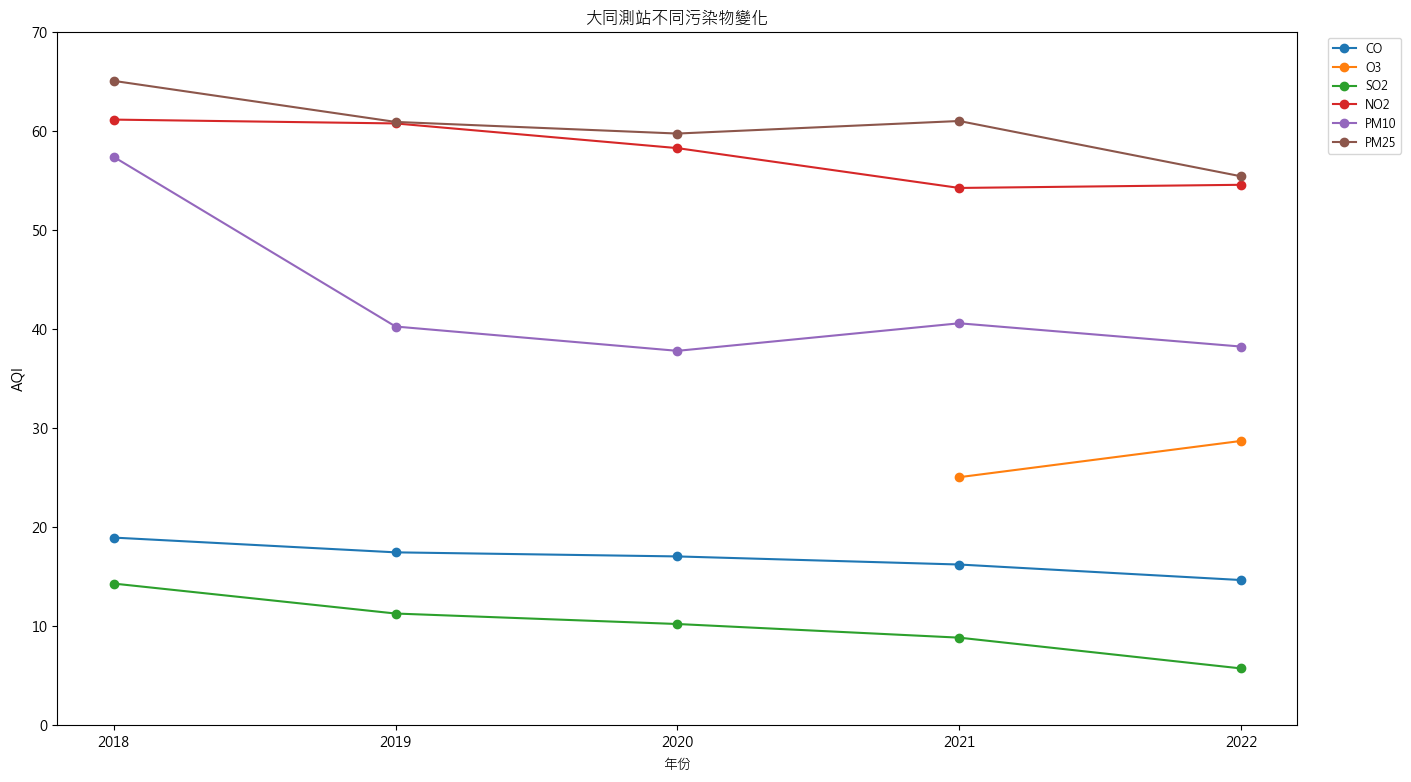

In [492]:
def plot1(data_name, index):
    x_labels = ['2018', '2019', '2020', '2021', '2022']
    y_values = [1, 2, 3, 4, 5]
    return x_labels, y_values
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Daton",0)[1].values()))),list(plot("Daton",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Daton",1)[1].values()))),list(plot("Daton",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Daton",2)[1].values()))),list(plot("Daton",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Daton",3)[1].values()))),list(plot("Daton",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Daton",4)[1].values()))),list(plot("Daton",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Daton",5)[1].values()))),list(plot("Daton",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Daton",0)[1].values()))),plot("Daton",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("大同測站不同污染物變化")
plt.show()

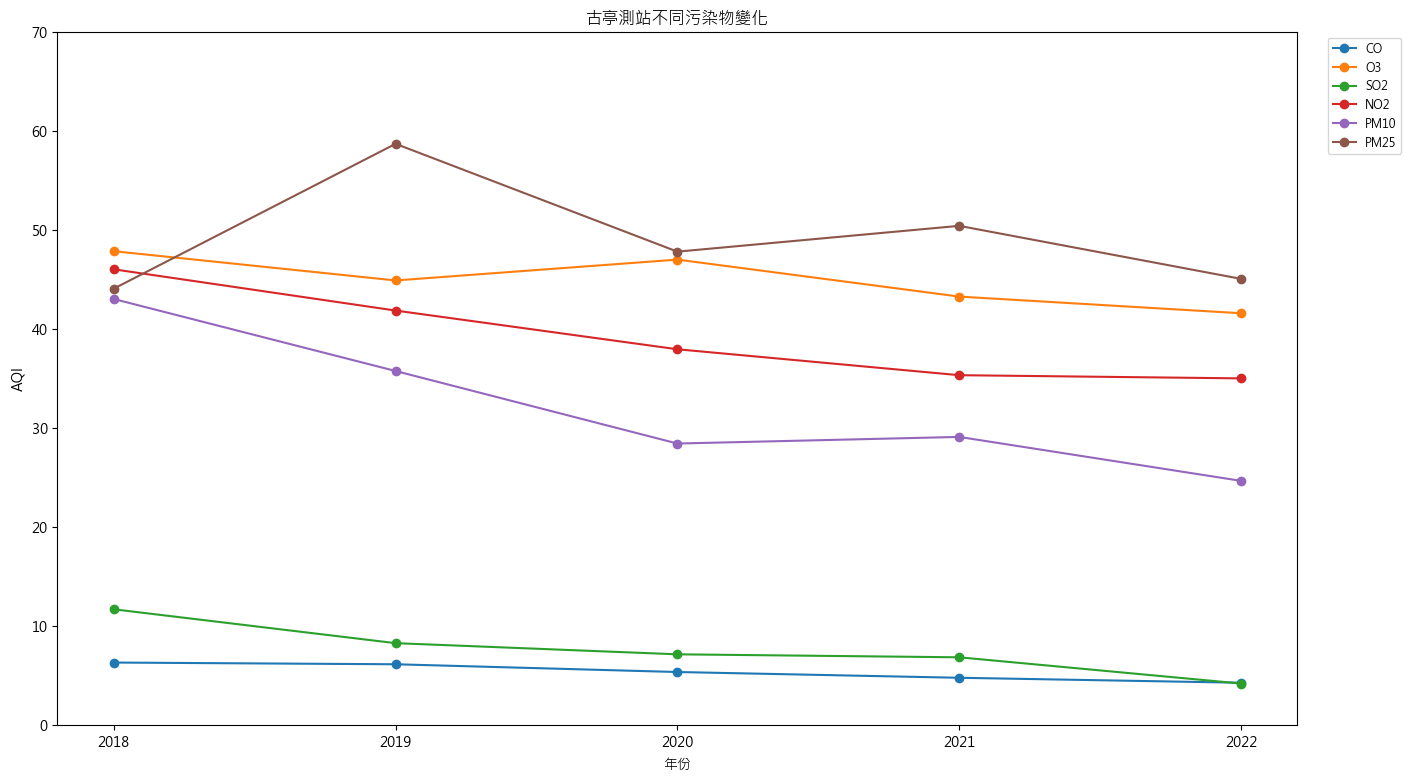

In [491]:
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Gutin",0)[1].values()))),list(plot("Gutin",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Gutin",1)[1].values()))),list(plot("Gutin",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Gutin",2)[1].values()))),list(plot("Gutin",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Gutin",3)[1].values()))),list(plot("Gutin",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Gutin",4)[1].values()))),list(plot("Gutin",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Gutin",5)[1].values()))),list(plot("Gutin",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Gutin",0)[1].values()))),plot("Gutin",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("古亭測站不同污染物變化")
plt.show()

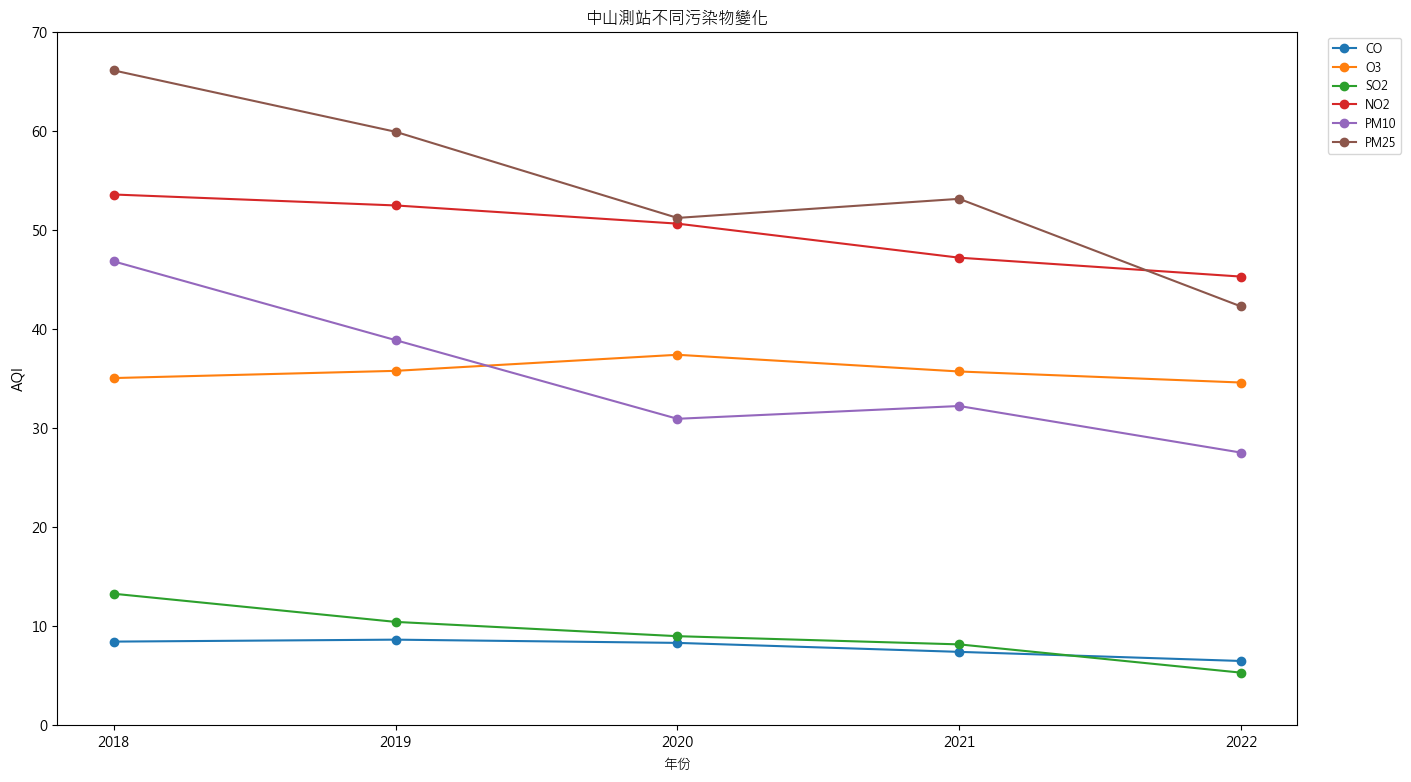

In [490]:
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Zhongshan",0)[1].values()))),list(plot("Zhongshan",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Zhongshan",1)[1].values()))),list(plot("Zhongshan",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Zhongshan",2)[1].values()))),list(plot("Zhongshan",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Zhongshan",3)[1].values()))),list(plot("Zhongshan",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Zhongshan",4)[1].values()))),list(plot("Zhongshan",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Zhongshan",5)[1].values()))),list(plot("Zhongshan",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Zhongshan",0)[1].values()))),plot("Zhongshan",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("中山測站不同污染物變化")
plt.show()

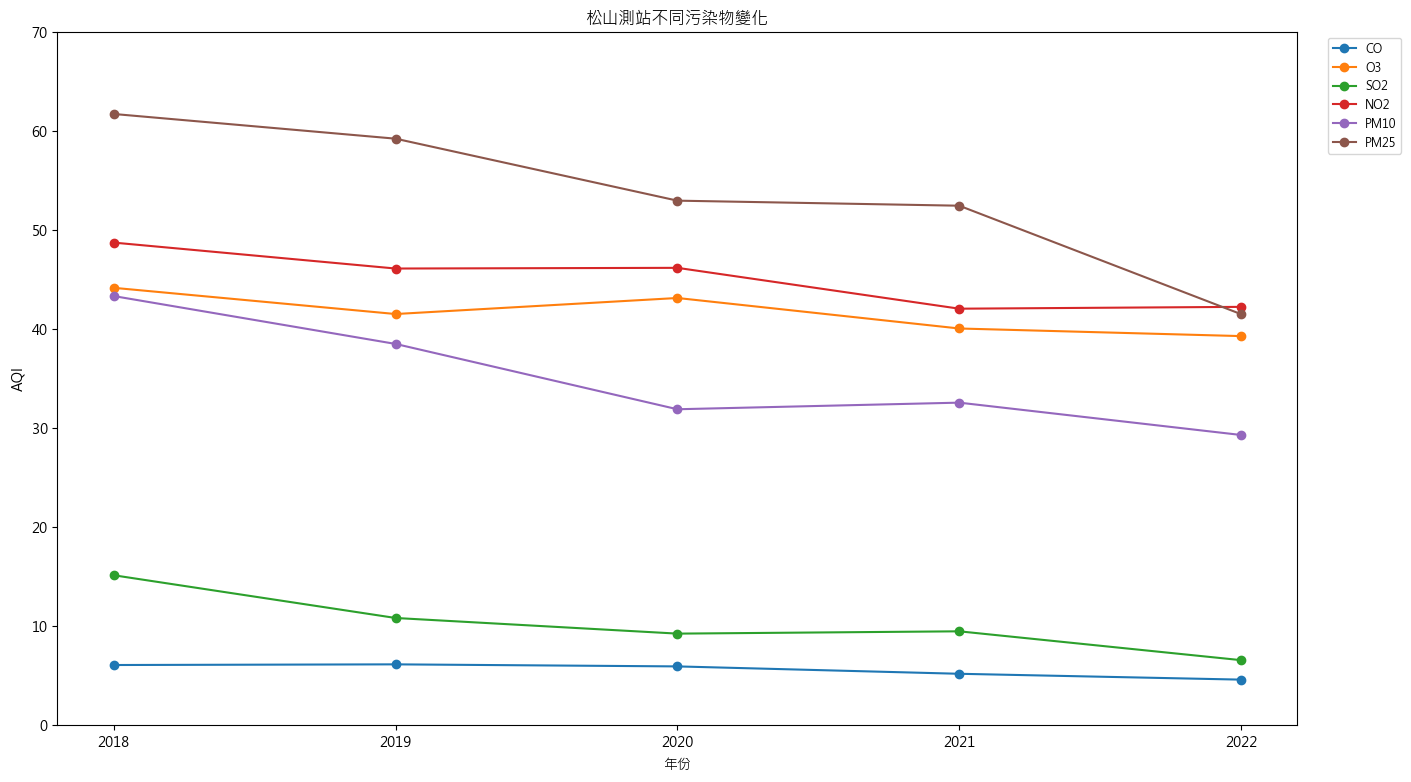

In [489]:
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Songshan",0)[1].values()))),list(plot("Songshan",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Songshan",1)[1].values()))),list(plot("Songshan",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Songshan",2)[1].values()))),list(plot("Songshan",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Songshan",3)[1].values()))),list(plot("Songshan",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Songshan",4)[1].values()))),list(plot("Songshan",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Songshan",5)[1].values()))),list(plot("Songshan",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Songshan",0)[1].values()))),plot("Songshan",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("松山測站不同污染物變化")
plt.show()

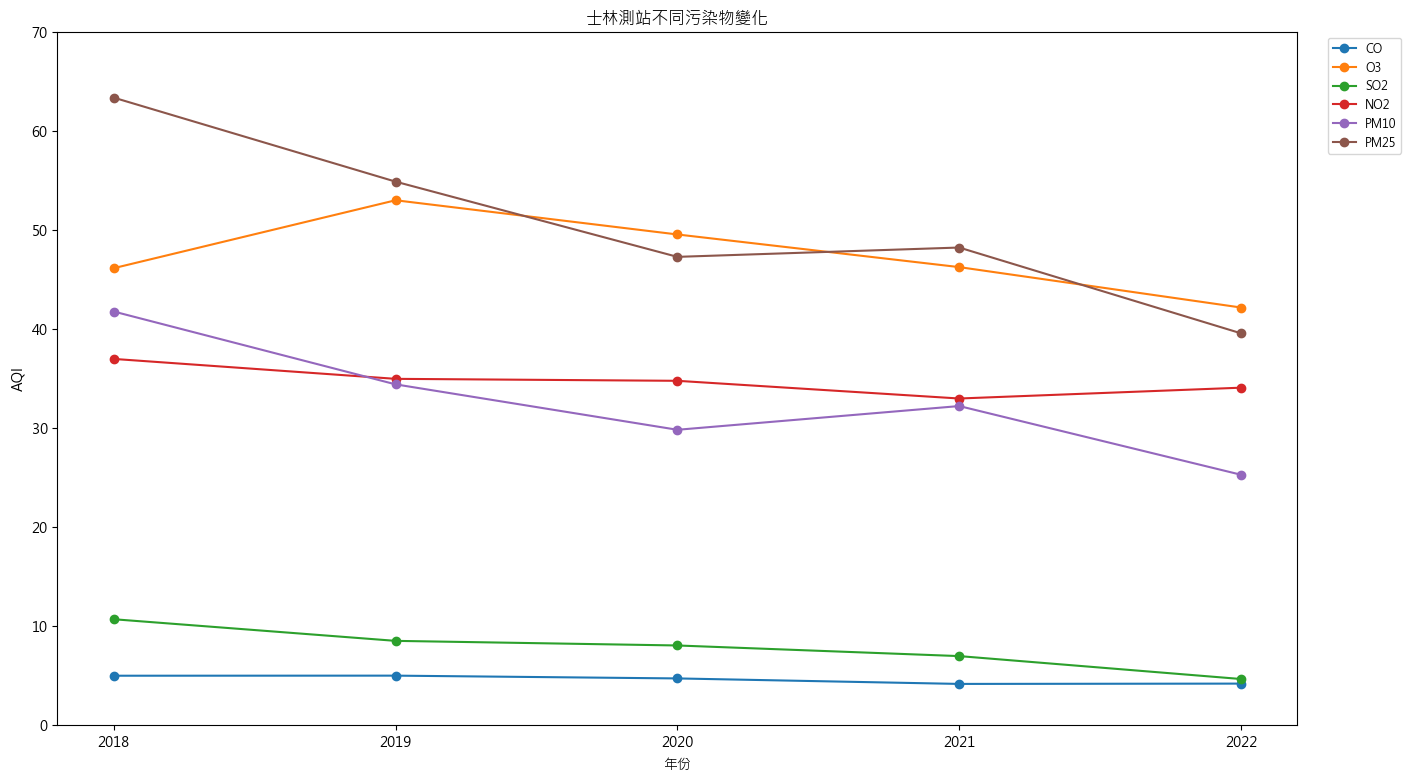

In [488]:
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Shilin",0)[1].values()))),list(plot("Shilin",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Shilin",1)[1].values()))),list(plot("Shilin",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Shilin",2)[1].values()))),list(plot("Shilin",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Shilin",3)[1].values()))),list(plot("Shilin",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Shilin",4)[1].values()))),list(plot("Shilin",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Shilin",5)[1].values()))),list(plot("Shilin",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Shilin",0)[1].values()))),plot("Shilin",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("士林測站不同污染物變化")
plt.show()

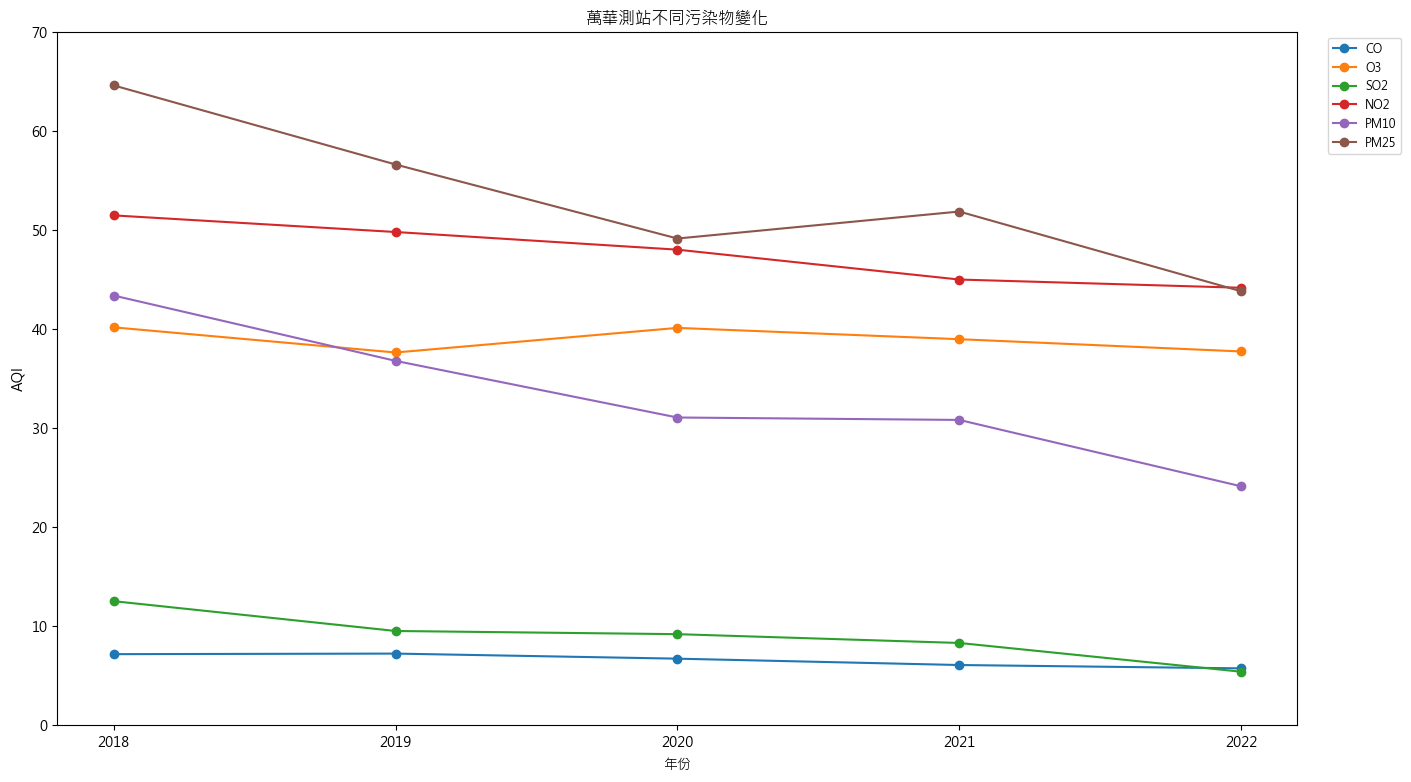

In [487]:
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Wanhua",0)[1].values()))),list(plot("Wanhua",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Wanhua",1)[1].values()))),list(plot("Wanhua",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Wanhua",2)[1].values()))),list(plot("Wanhua",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Wanhua",3)[1].values()))),list(plot("Wanhua",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Wanhua",4)[1].values()))),list(plot("Wanhua",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Wanhua",5)[1].values()))),list(plot("Wanhua",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Wanhua",0)[1].values()))),plot("Wanhua",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("萬華測站不同污染物變化")
plt.show()

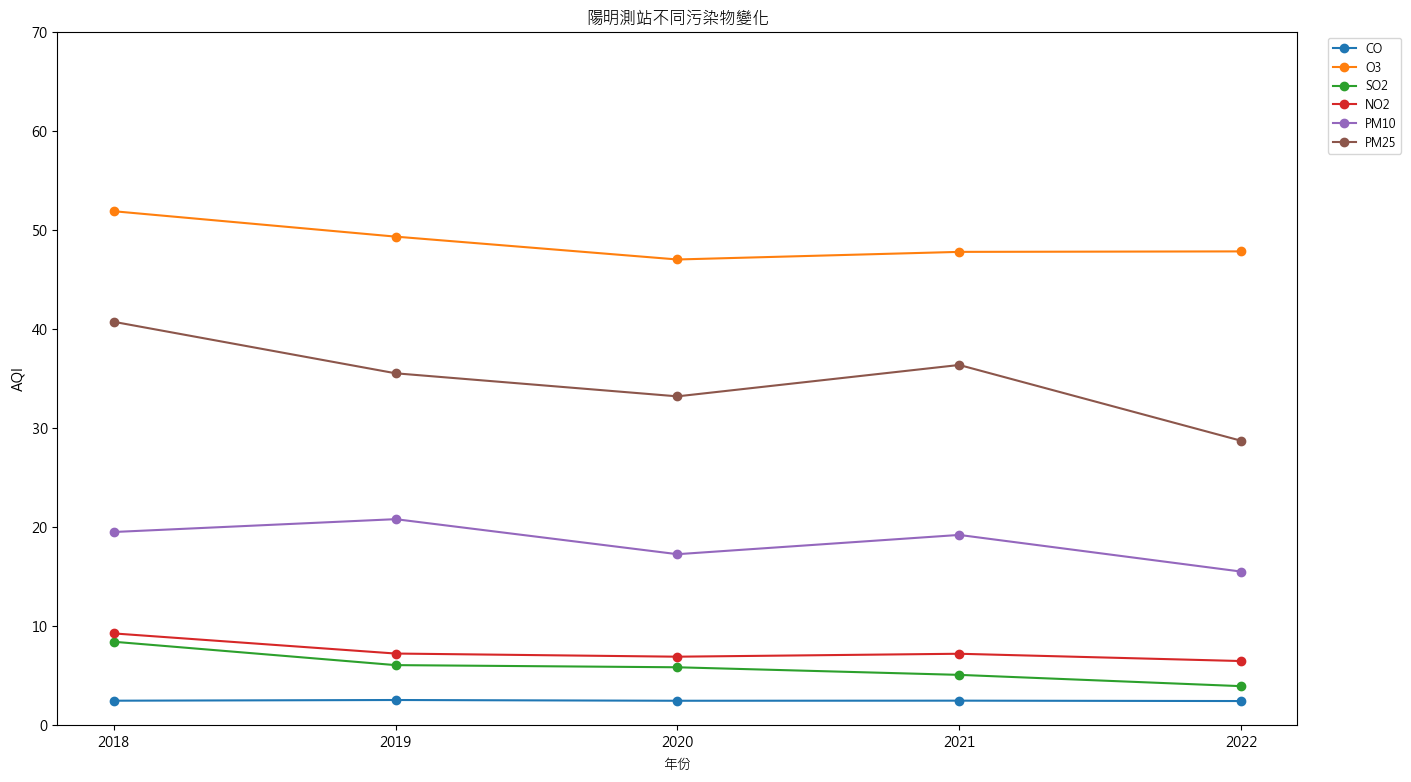

In [486]:
plt.figure(figsize=(16,9))
plt.plot(range(len(list(plot("Yangming",0)[1].values()))),list(plot("Yangming",0)[1].values()),marker="o",label="CO")
plt.plot(range(len(list(plot("Yangming",1)[1].values()))),list(plot("Yangming",1)[1].values()),marker="o",label="O3")
plt.plot(range(len(list(plot("Yangming",2)[1].values()))),list(plot("Yangming",2)[1].values()),marker="o",label="SO2")
plt.plot(range(len(list(plot("Yangming",3)[1].values()))),list(plot("Yangming",3)[1].values()),marker="o",label="NO2")
plt.plot(range(len(list(plot("Yangming",4)[1].values()))),list(plot("Yangming",4)[1].values()),marker="o",label="PM10")
plt.plot(range(len(list(plot("Yangming",5)[1].values()))),list(plot("Yangming",5)[1].values()),marker="o",label="PM25")
plt.legend(fontsize='small',bbox_to_anchor=(1.02, 1),loc='upper left')
plt.xticks(range(len(list(plot("Yangming",0)[1].values()))),plot("Yangming",0)[1])
plt.xlabel("年份")
plt.ylabel("AQI")
plt.ylim(0,70)
plt.title("陽明測站不同污染物變化")
plt.show()

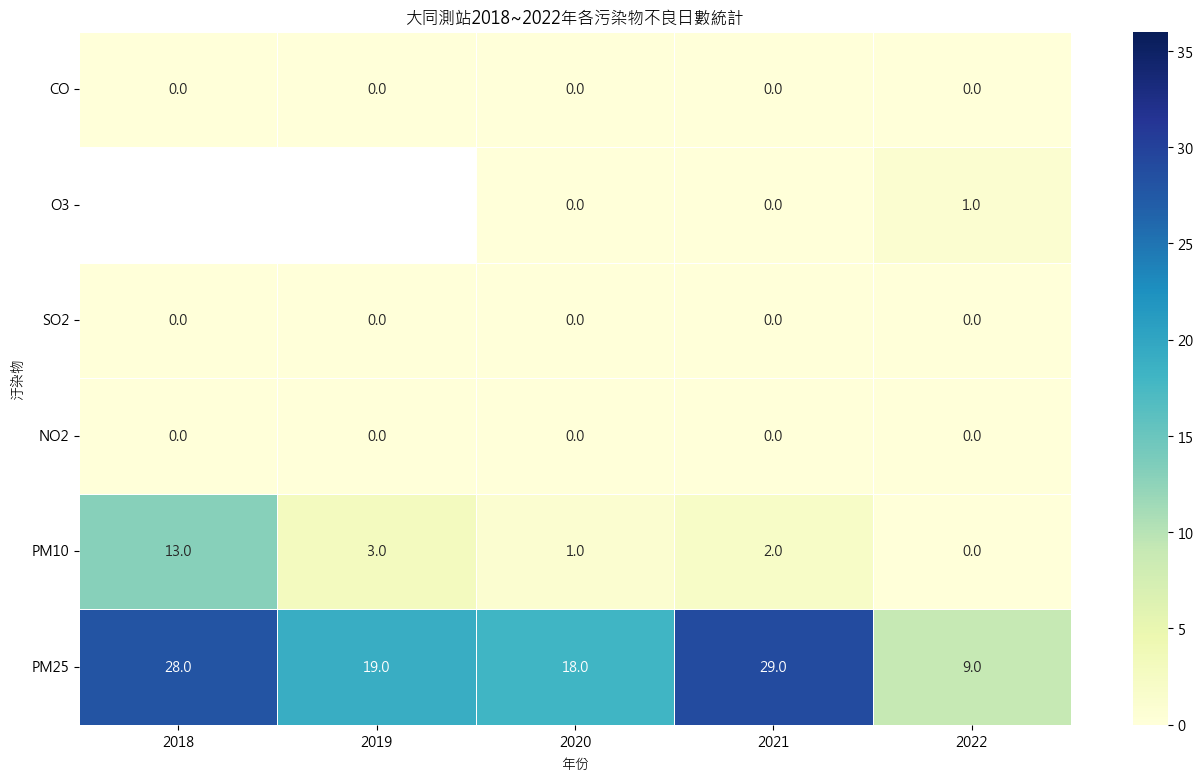

In [510]:
import seaborn as sns
Years = [2018,2019,2020,2021,2022]
AQI_ALL = pd.DataFrame({"CO":plot("Daton",0)[3],"O3":plot("Daton",1)[3],"SO2":plot("Daton",2)[3],"NO2":plot("Daton",3)[3],"PM10":plot("Daton",4)[3],"PM25":plot("Daton",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('大同測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

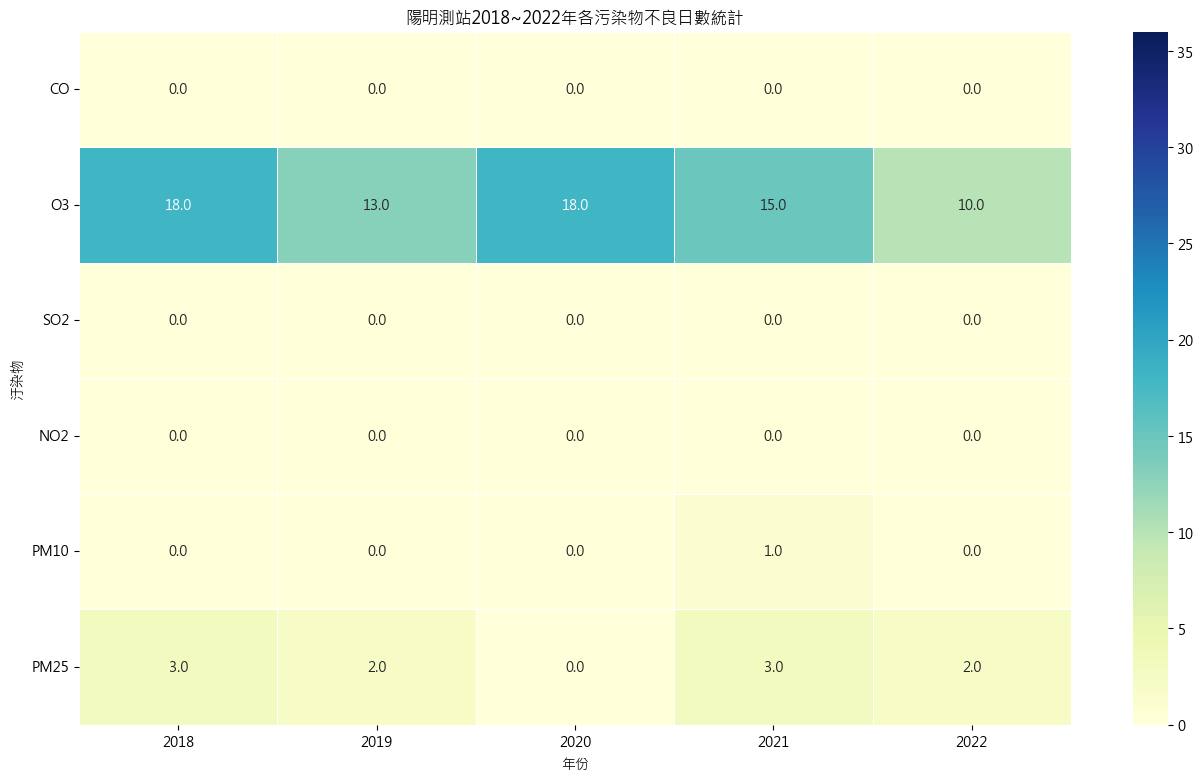

In [509]:
AQI_ALL = pd.DataFrame({"CO":plot("Yangming",0)[3],"O3":plot("Yangming",1)[3],"SO2":plot("Yangming",2)[3],"NO2":plot("Yangming",3)[3],"PM10":plot("Yangming",4)[3],"PM25":plot("Yangming",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('陽明測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

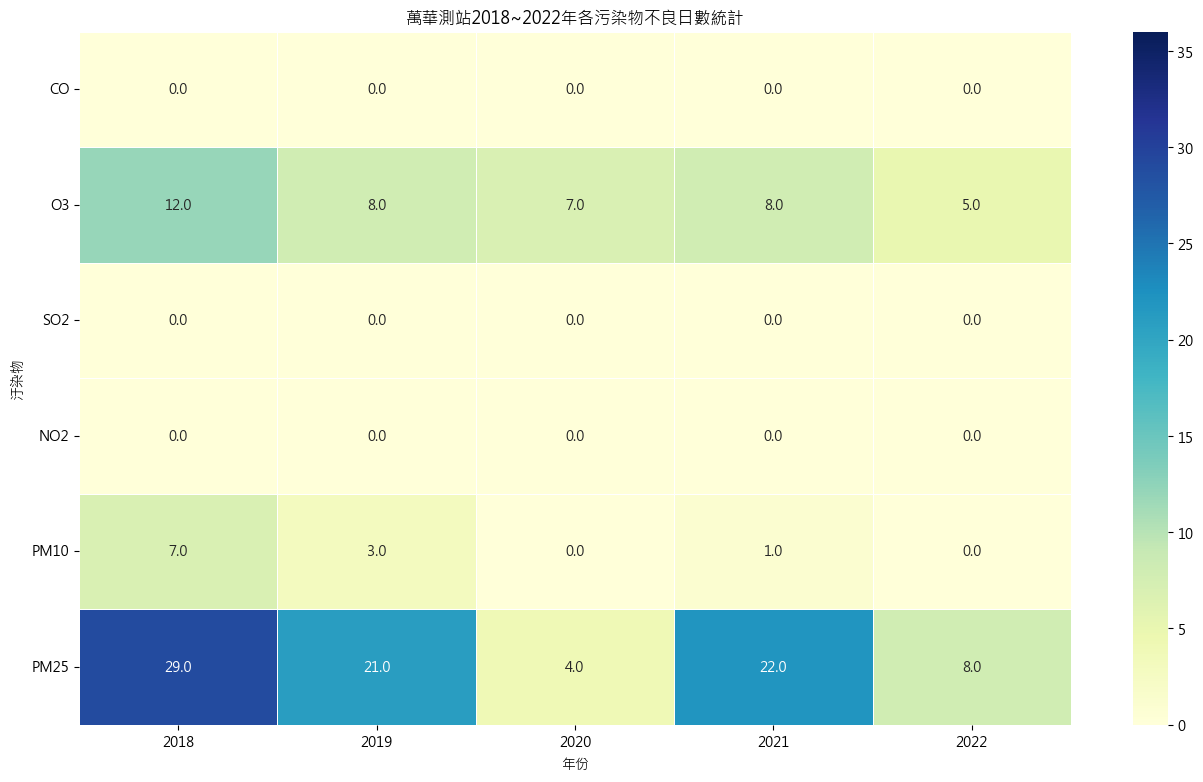

In [508]:
AQI_ALL = pd.DataFrame({"CO":plot("Wanhua",0)[3],"O3":plot("Wanhua",1)[3],"SO2":plot("Wanhua",2)[3],"NO2":plot("Wanhua",3)[3],"PM10":plot("Wanhua",4)[3],"PM25":plot("Wanhua",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('萬華測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

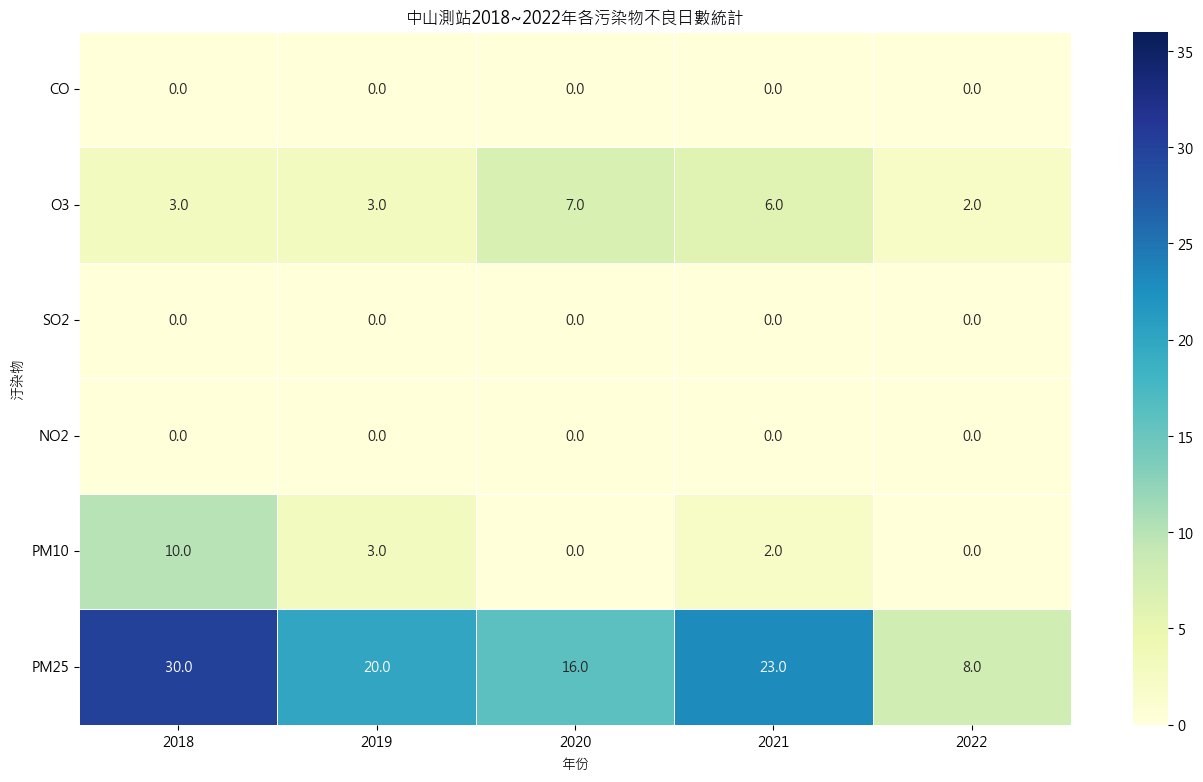

In [507]:
AQI_ALL = pd.DataFrame({"CO":plot("Zhongshan",0)[3],"O3":plot("Zhongshan",1)[3],"SO2":plot("Zhongshan",2)[3],"NO2":plot("Zhongshan",3)[3],"PM10":plot("Zhongshan",4)[3],"PM25":plot("Zhongshan",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('中山測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

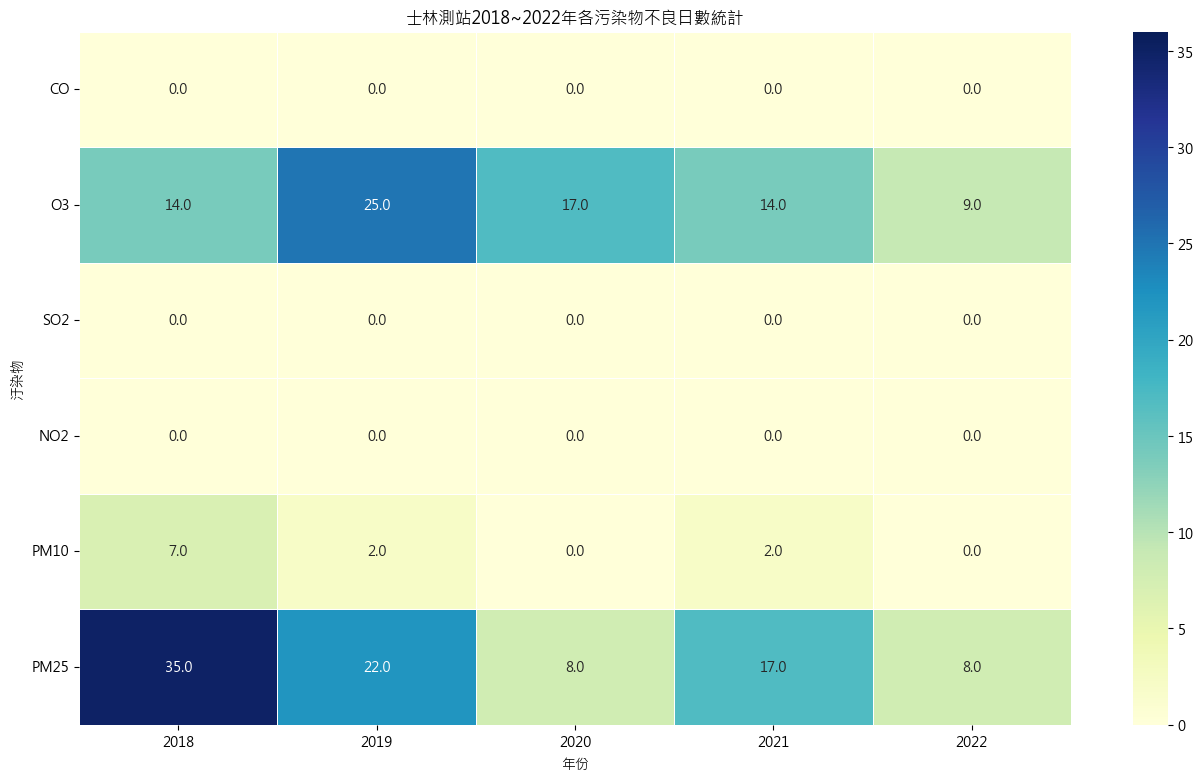

In [505]:
AQI_ALL = pd.DataFrame({"CO":plot("Shilin",0)[3],"O3":plot("Shilin",1)[3],"SO2":plot("Shilin",2)[3],"NO2":plot("Shilin",3)[3],"PM10":plot("Shilin",4)[3],"PM25":plot("Shilin",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('士林測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

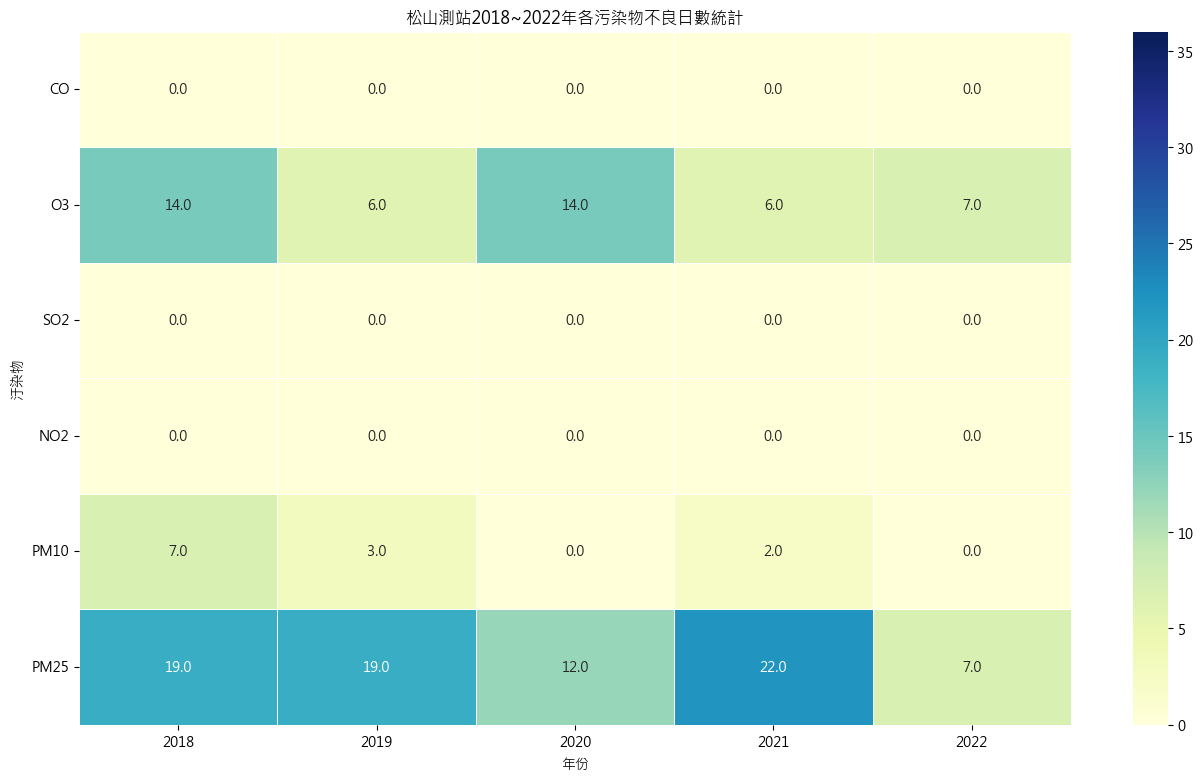

In [504]:
AQI_ALL = pd.DataFrame({"CO":plot("Songshan",0)[3],"O3":plot("Songshan",1)[3],"SO2":plot("Songshan",2)[3],"NO2":plot("Songshan",3)[3],"PM10":plot("Songshan",4)[3],"PM25":plot("Songshan",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('松山測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

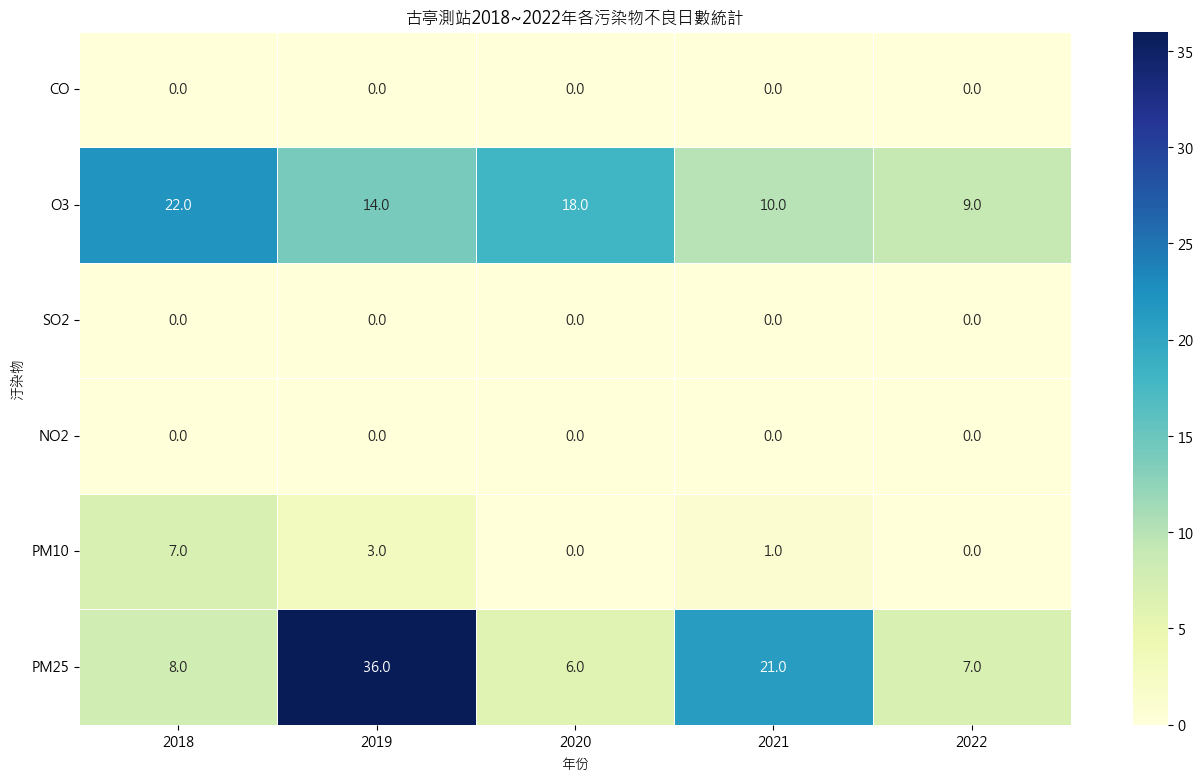

In [506]:
AQI_ALL = pd.DataFrame({"CO":plot("Gutin",0)[3],"O3":plot("Gutin",1)[3],"SO2":plot("Gutin",2)[3],"NO2":plot("Gutin",3)[3],"PM10":plot("Gutin",4)[3],"PM25":plot("Gutin",5)[3]})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5,vmin=0, vmax=36)
plt.title('古亭測站2018~2022年各污染物不良日數統計')
plt.xlabel('年份')
plt.ylabel('汙染物')
plt.yticks(rotation='horizontal')
plt.show()

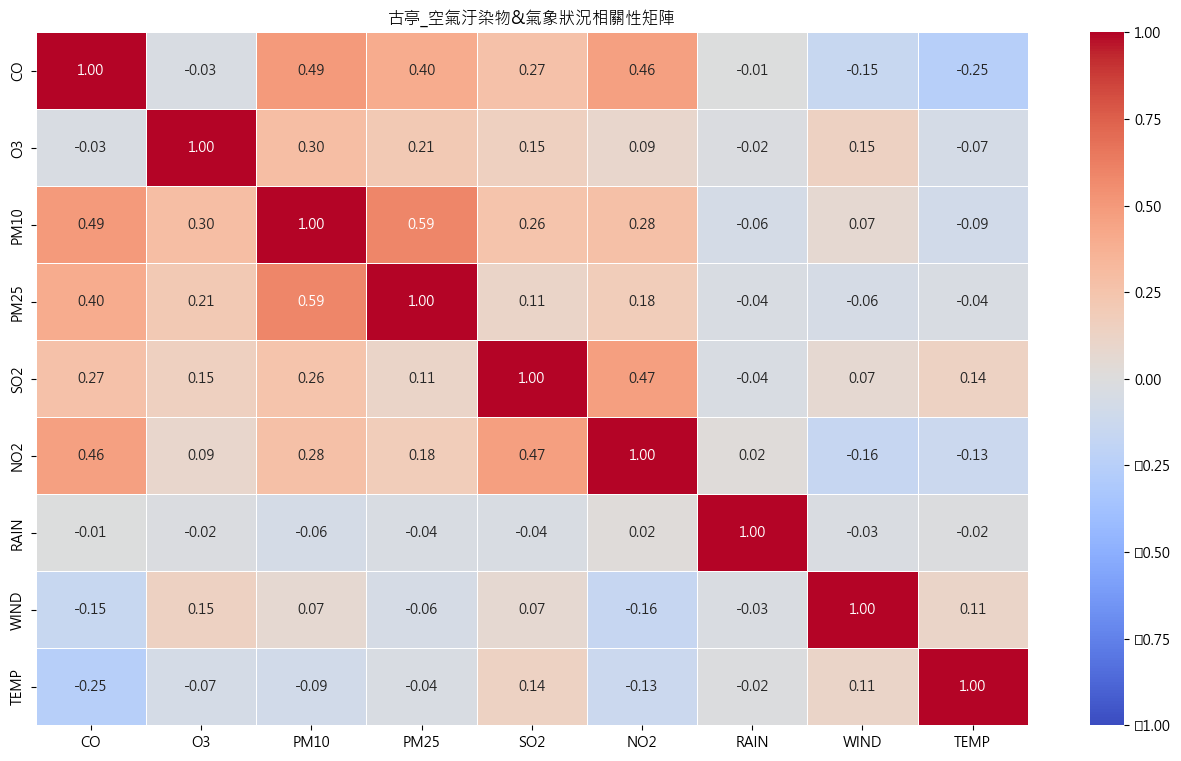

In [300]:
import seaborn as sns
gutin_co = AQI_dict["Gutin_df_CO"]
co_gutin = []
gutin_o3 = AQI_dict["Gutin_df_O3"]
o3_gutin = []
gutin_no2 = AQI_dict["Gutin_df_NO2"]
no2_gutin = []
gutin_so2 = AQI_dict["Gutin_df_SO2"]
so2_gutin = []
gutin_pm25 = AQI_dict["Gutin_df_PM25"]
pm25_gutin = []
gutin_pm10 = AQI_dict["Gutin_df_PM10"]
pm10_gutin = []
gutin_temp = AQI_dict["Gutin_df_temp"]
temp_gutin = []
gutin_wind = AQI_dict["Gutin_df_wind"]
wind_gutin = []
gutin_rain = AQI_dict["Gutin_df_rain"]
rain_gutin = []
gutin_date = set(gutin_pm25.keys())&set(gutin_rain.keys())&set(gutin_pm10.keys())&set(gutin_o3.keys())&set(gutin_so2.keys())&set(gutin_no2.keys())&set(gutin_co.keys())&set(gutin_wind.keys())&set(gutin_rain.keys())
gutin_date = sorted(list(gutin_date))
for w1 in range(len(gutin_date)):
    for w2 in range(len(gutin_co[gutin_date[w1]])):
        co_gutin.append(gutin_co[gutin_date[w1]][w2])
    for w3 in range(len(gutin_o3[gutin_date[w1]])):
        o3_gutin.append(gutin_o3[gutin_date[w1]][w3])
    for w4 in range(len(gutin_pm25[gutin_date[w1]])):
        pm25_gutin.append(gutin_pm25[gutin_date[w1]][w4])
    for w5 in range(len(gutin_pm10[gutin_date[w1]])):
        pm10_gutin.append(gutin_pm10[gutin_date[w1]][w5])
    for w6 in range(len(gutin_so2[gutin_date[w1]])):
        so2_gutin.append(gutin_so2[gutin_date[w1]][w6])
    for w7 in range(len(gutin_no2[gutin_date[w1]])):
        no2_gutin.append(gutin_no2[gutin_date[w1]][w7])
    for w8 in range(len(gutin_temp[gutin_date[w1]])):
        temp_gutin.append(gutin_temp[gutin_date[w1]][w8])
    for w9 in range(len(gutin_rain[gutin_date[w1]])):
        rain_gutin.append(gutin_rain[gutin_date[w1]][w9])
    for w10 in range(len(gutin_wind[gutin_date[w1]])):
        wind_gutin.append(gutin_wind[gutin_date[w1]][w10])
gutin_all = {"CO":co_gutin,"O3":o3_gutin,"PM10":pm10_gutin,"PM25":pm25_gutin,"NO2":no2_gutin,"SO2":so2_gutin,"TEMP":temp_gutin,"RAIN":rain_gutin,"WIND":wind_gutin}
gutin_all_df = pd.DataFrame(gutin_all)
gutin_pollutants = ['CO','O3','PM10','PM25','SO2','NO2']
gutin_weather_variables = ['RAIN','WIND','TEMP']
gutin_selected_columns = gutin_pollutants + gutin_weather_variables
gutin_sub_df = gutin_all_df[gutin_selected_columns]
correlation_matrix = gutin_sub_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('古亭_空氣汙染物&氣象狀況相關性矩陣')
plt.show()

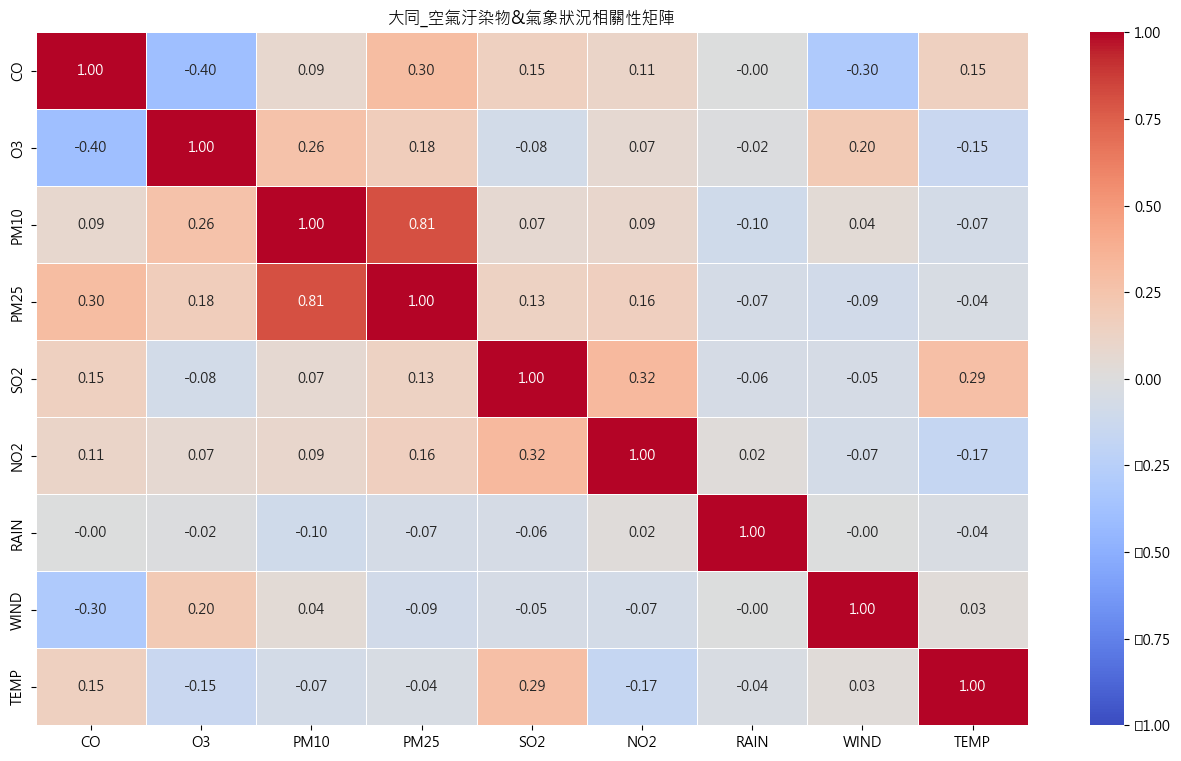

In [299]:
import seaborn as sns
daton_co = AQI_dict["Daton_df_CO"]
co_daton = []
daton_o3 = AQI_dict["Daton_df_O3"]
o3_daton = []
daton_no2 = AQI_dict["Daton_df_NO2"]
no2_daton = []
daton_so2 = AQI_dict["Daton_df_SO2"]
so2_daton = []
daton_pm25 = AQI_dict["Daton_df_PM25"]
pm25_daton = []
daton_pm10 = AQI_dict["Daton_df_PM10"]
pm10_daton = []
daton_temp = AQI_dict["Daton_df_temp"]
temp_daton = []
daton_wind = AQI_dict["Daton_df_wind"]
wind_daton = []
daton_rain = AQI_dict["Daton_df_rain"]
rain_daton = []
daton_date = set(daton_pm25.keys())&set(daton_rain.keys())&set(daton_pm10.keys())&set(daton_o3.keys())&set(daton_so2.keys())&set(daton_no2.keys())&set(daton_co.keys())&set(daton_wind.keys())&set(daton_rain.keys())
daton_date = sorted(list(daton_date))
for w1 in range(len(daton_date)):
    for w2 in range(len(daton_co[daton_date[w1]])):
        co_daton.append(daton_co[daton_date[w1]][w2])
    for w3 in range(len(daton_o3[daton_date[w1]])):
        o3_daton.append(daton_o3[daton_date[w1]][w3])
    for w4 in range(len(daton_pm25[daton_date[w1]])):
        pm25_daton.append(daton_pm25[daton_date[w1]][w4])
    for w5 in range(len(daton_pm10[daton_date[w1]])):
        pm10_daton.append(daton_pm10[daton_date[w1]][w5])
    for w6 in range(len(daton_so2[daton_date[w1]])):
        so2_daton.append(daton_so2[daton_date[w1]][w6])
    for w7 in range(len(daton_no2[daton_date[w1]])):
        no2_daton.append(daton_no2[daton_date[w1]][w7])
    for w8 in range(len(daton_temp[daton_date[w1]])):
        temp_daton.append(daton_temp[daton_date[w1]][w8])
    for w9 in range(len(daton_rain[daton_date[w1]])):
        rain_daton.append(daton_rain[daton_date[w1]][w9])
    for w10 in range(len(daton_wind[daton_date[w1]])):
        wind_daton.append(daton_wind[daton_date[w1]][w10])
daton_all = {"CO":co_daton,"O3":o3_daton,"PM10":pm10_daton,"PM25":pm25_daton,"NO2":no2_daton,"SO2":so2_daton,"TEMP":temp_daton,"RAIN":rain_daton,"WIND":wind_daton}
daton_all_df = pd.DataFrame(daton_all)
daton_pollutants = ['CO','O3','PM10','PM25','SO2','NO2']
daton_weather_variables = ['RAIN','WIND','TEMP']
daton_selected_columns = daton_pollutants + daton_weather_variables
daton_sub_df = daton_all_df[daton_selected_columns]
correlation_matrix = daton_sub_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('大同_空氣汙染物&氣象狀況相關性矩陣')
plt.show()

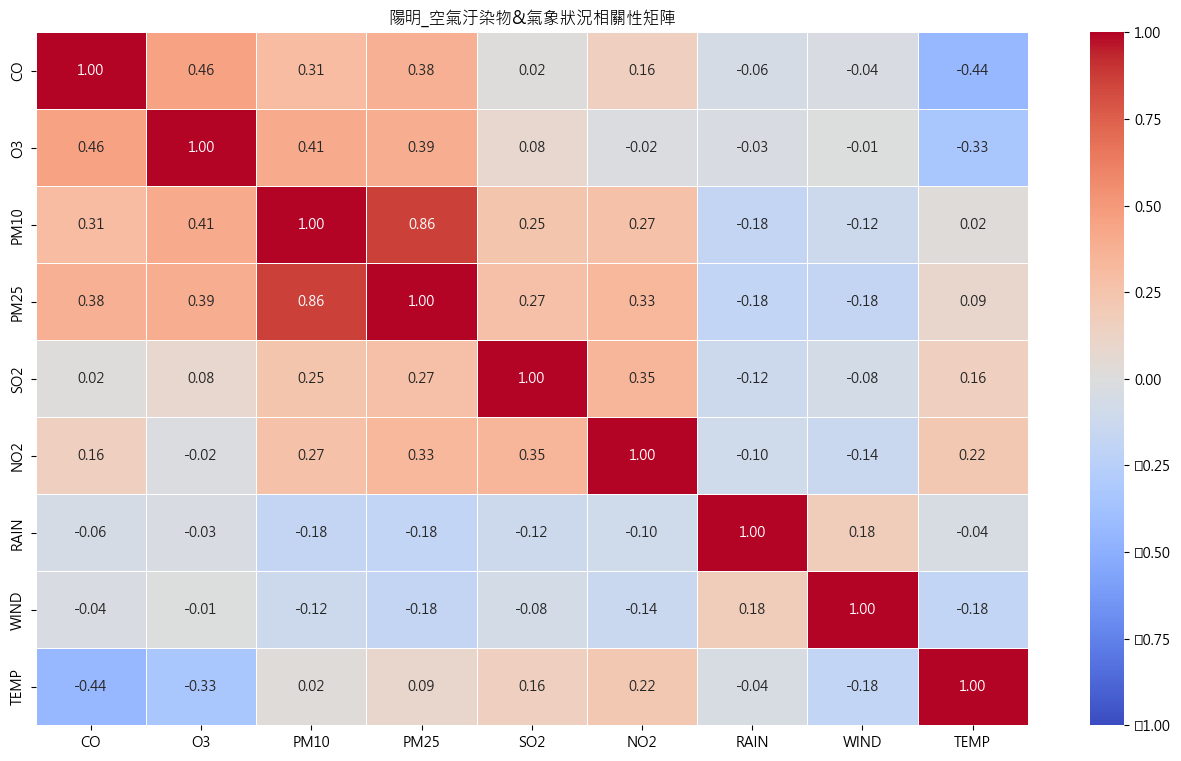

In [298]:
import seaborn as sns
Yangming_co = AQI_dict["Yangming_df_CO"]
co_Yangming = []
Yangming_o3 = AQI_dict["Yangming_df_O3"]
o3_Yangming = []
Yangming_no2 = AQI_dict["Yangming_df_NO2"]
no2_Yangming = []
Yangming_so2 = AQI_dict["Yangming_df_SO2"]
so2_Yangming = []
Yangming_pm25 = AQI_dict["Yangming_df_PM25"]
pm25_Yangming = []
Yangming_pm10 = AQI_dict["Yangming_df_PM10"]
pm10_Yangming = []
Yangming_temp = AQI_dict["Yangming_df_temp"]
temp_Yangming = []
Yangming_wind = AQI_dict["Yangming_df_wind"]
wind_Yangming = []
Yangming_rain = AQI_dict["Yangming_df_rain"]
rain_Yangming = []
Yangming_date = set(Yangming_pm25.keys())&set(Yangming_rain.keys())&set(Yangming_pm10.keys())&set(Yangming_o3.keys())&set(Yangming_so2.keys())&set(Yangming_no2.keys())&set(Yangming_co.keys())&set(Yangming_wind.keys())&set(Yangming_rain.keys())
Yangming_date = sorted(list(Yangming_date))
for w1 in range(len(Yangming_date)):
    for w2 in range(len(Yangming_co[Yangming_date[w1]])):
        co_Yangming.append(Yangming_co[Yangming_date[w1]][w2])
    for w3 in range(len(Yangming_o3[Yangming_date[w1]])):
        o3_Yangming.append(Yangming_o3[Yangming_date[w1]][w3])
    for w4 in range(len(Yangming_pm25[Yangming_date[w1]])):
        pm25_Yangming.append(Yangming_pm25[Yangming_date[w1]][w4])
    for w5 in range(len(Yangming_pm10[Yangming_date[w1]])):
        pm10_Yangming.append(Yangming_pm10[Yangming_date[w1]][w5])
    for w6 in range(len(Yangming_so2[Yangming_date[w1]])):
        so2_Yangming.append(Yangming_so2[Yangming_date[w1]][w6])
    for w7 in range(len(Yangming_no2[Yangming_date[w1]])):
        no2_Yangming.append(Yangming_no2[Yangming_date[w1]][w7])
    for w8 in range(len(Yangming_temp[Yangming_date[w1]])):
        temp_Yangming.append(Yangming_temp[Yangming_date[w1]][w8])
    for w9 in range(len(Yangming_rain[Yangming_date[w1]])):
        rain_Yangming.append(Yangming_rain[Yangming_date[w1]][w9])
    for w10 in range(len(Yangming_wind[Yangming_date[w1]])):
        wind_Yangming.append(Yangming_wind[Yangming_date[w1]][w10])
Yangming_all = {"CO":co_Yangming,"O3":o3_Yangming,"PM10":pm10_Yangming,"PM25":pm25_Yangming,"NO2":no2_Yangming,"SO2":so2_Yangming,"TEMP":temp_Yangming,"RAIN":rain_Yangming,"WIND":wind_Yangming}
Yangming_all_df = pd.DataFrame(Yangming_all)
Yangming_pollutants = ['CO','O3','PM10','PM25','SO2','NO2']
Yangming_weather_variables = ['RAIN','WIND','TEMP']
Yangming_selected_columns = Yangming_pollutants + Yangming_weather_variables
Yangming_sub_df = Yangming_all_df[Yangming_selected_columns]
correlation_matrix = Yangming_sub_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('陽明_空氣汙染物&氣象狀況相關性矩陣')
plt.show()

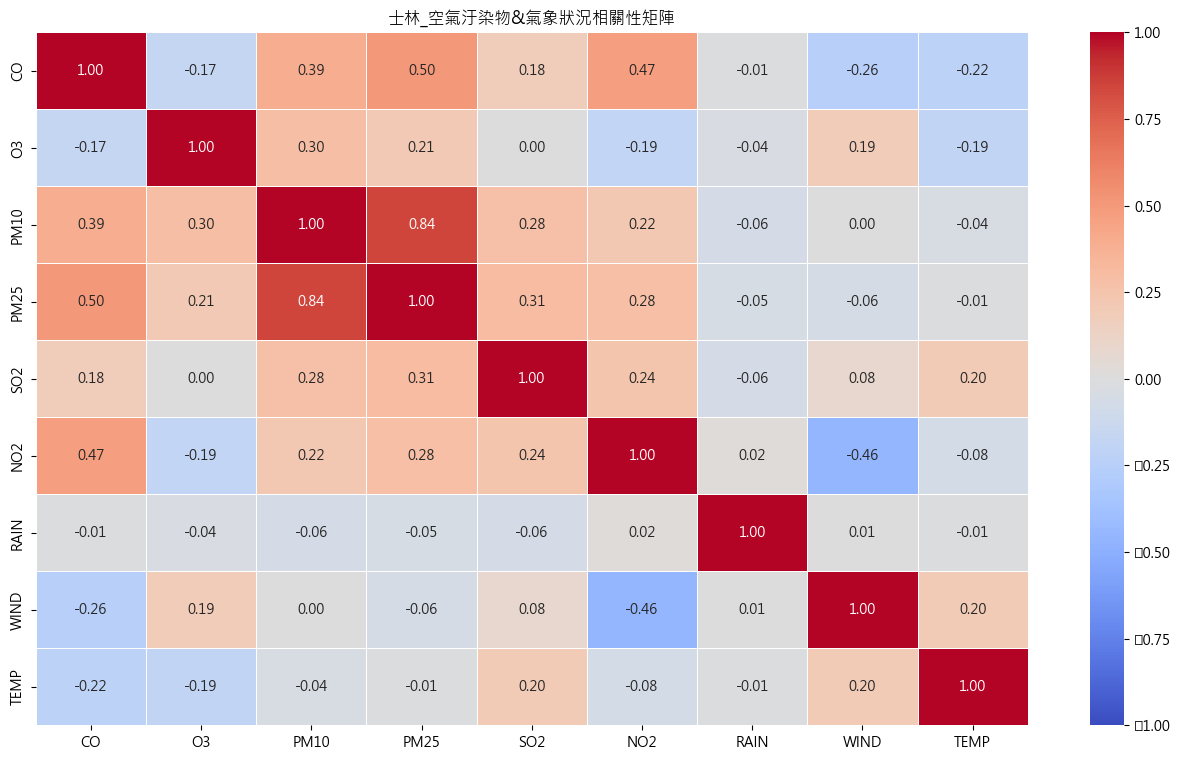

In [297]:
import seaborn as sns
Shilin_co = AQI_dict["Shilin_df_CO"]
co_Shilin = []
Shilin_o3 = AQI_dict["Shilin_df_O3"]
o3_Shilin = []
Shilin_no2 = AQI_dict["Shilin_df_NO2"]
no2_Shilin = []
Shilin_so2 = AQI_dict["Shilin_df_SO2"]
so2_Shilin = []
Shilin_pm25 = AQI_dict["Shilin_df_PM25"]
pm25_Shilin = []
Shilin_pm10 = AQI_dict["Shilin_df_PM10"]
pm10_Shilin = []
Shilin_temp = AQI_dict["Shilin_df_temp"]
temp_Shilin = []
Shilin_wind = AQI_dict["Shilin_df_wind"]
wind_Shilin = []
Shilin_rain = AQI_dict["Shilin_df_rain"]
rain_Shilin = []
Shilin_date = set(Shilin_pm25.keys())&set(Shilin_rain.keys())&set(Shilin_pm10.keys())&set(Shilin_o3.keys())&set(Shilin_so2.keys())&set(Shilin_no2.keys())&set(Shilin_co.keys())&set(Shilin_wind.keys())&set(Shilin_rain.keys())
Shilin_date = sorted(list(Shilin_date))
for w1 in range(len(Shilin_date)):
    for w2 in range(len(Shilin_co[Shilin_date[w1]])):
        co_Shilin.append(Shilin_co[Shilin_date[w1]][w2])
    for w3 in range(len(Shilin_o3[Shilin_date[w1]])):
        o3_Shilin.append(Shilin_o3[Shilin_date[w1]][w3])
    for w4 in range(len(Shilin_pm25[Shilin_date[w1]])):
        pm25_Shilin.append(Shilin_pm25[Shilin_date[w1]][w4])
    for w5 in range(len(Shilin_pm10[Shilin_date[w1]])):
        pm10_Shilin.append(Shilin_pm10[Shilin_date[w1]][w5])
    for w6 in range(len(Shilin_so2[Shilin_date[w1]])):
        so2_Shilin.append(Shilin_so2[Shilin_date[w1]][w6])
    for w7 in range(len(Shilin_no2[Shilin_date[w1]])):
        no2_Shilin.append(Shilin_no2[Shilin_date[w1]][w7])
    for w8 in range(len(Shilin_temp[Shilin_date[w1]])):
        temp_Shilin.append(Shilin_temp[Shilin_date[w1]][w8])
    for w9 in range(len(Shilin_rain[Shilin_date[w1]])):
        rain_Shilin.append(Shilin_rain[Shilin_date[w1]][w9])
    for w10 in range(len(Shilin_wind[Shilin_date[w1]])):
        wind_Shilin.append(Shilin_wind[Shilin_date[w1]][w10])
Shilin_all = {"CO":co_Shilin,"O3":o3_Shilin,"PM10":pm10_Shilin,"PM25":pm25_Shilin,"NO2":no2_Shilin,"SO2":so2_Shilin,"TEMP":temp_Shilin,"RAIN":rain_Shilin,"WIND":wind_Shilin}
Shilin_all_df = pd.DataFrame(Shilin_all)
Shilin_pollutants = ['CO','O3','PM10','PM25','SO2','NO2']
Shilin_weather_variables = ['RAIN','WIND','TEMP']
Shilin_selected_columns = Shilin_pollutants + Shilin_weather_variables
Shilin_sub_df = Shilin_all_df[Shilin_selected_columns]
correlation_matrix = Shilin_sub_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('士林_空氣汙染物&氣象狀況相關性矩陣')
plt.show()

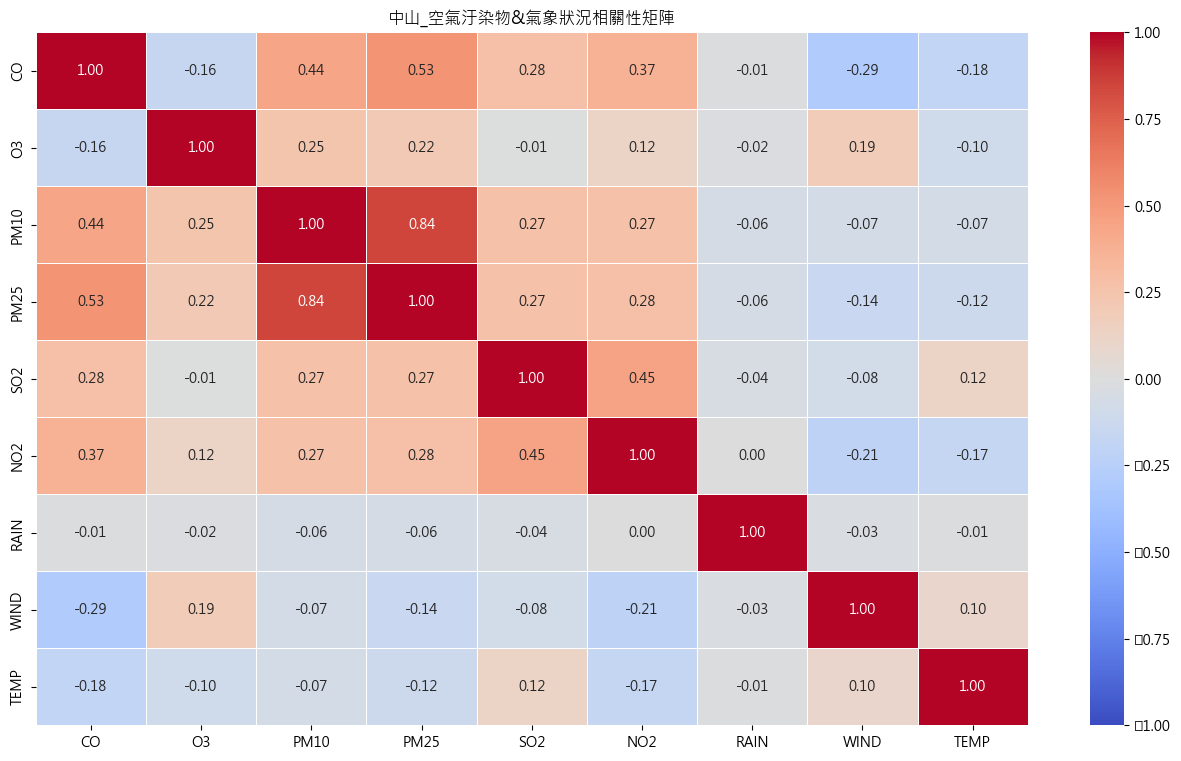

In [296]:
import seaborn as sns
Zhongshan_co = AQI_dict["Zhongshan_df_CO"]
co_Zhongshan = []
Zhongshan_o3 = AQI_dict["Zhongshan_df_O3"]
o3_Zhongshan = []
Zhongshan_no2 = AQI_dict["Zhongshan_df_NO2"]
no2_Zhongshan = []
Zhongshan_so2 = AQI_dict["Zhongshan_df_SO2"]
so2_Zhongshan = []
Zhongshan_pm25 = AQI_dict["Zhongshan_df_PM25"]
pm25_Zhongshan = []
Zhongshan_pm10 = AQI_dict["Zhongshan_df_PM10"]
pm10_Zhongshan = []
Zhongshan_temp = AQI_dict["Zhongshan_df_temp"]
temp_Zhongshan = []
Zhongshan_wind = AQI_dict["Zhongshan_df_wind"]
wind_Zhongshan = []
Zhongshan_rain = AQI_dict["Zhongshan_df_rain"]
rain_Zhongshan = []
Zhongshan_date = set(Zhongshan_pm25.keys())&set(Zhongshan_rain.keys())&set(Zhongshan_pm10.keys())&set(Zhongshan_o3.keys())&set(Zhongshan_so2.keys())&set(Zhongshan_no2.keys())&set(Zhongshan_co.keys())&set(Zhongshan_wind.keys())&set(Zhongshan_rain.keys())
Zhongshan_date = sorted(list(Zhongshan_date))
for w1 in range(len(Zhongshan_date)):
    for w2 in range(len(Zhongshan_co[Zhongshan_date[w1]])):
        co_Zhongshan.append(Zhongshan_co[Zhongshan_date[w1]][w2])
    for w3 in range(len(Zhongshan_o3[Zhongshan_date[w1]])):
        o3_Zhongshan.append(Zhongshan_o3[Zhongshan_date[w1]][w3])
    for w4 in range(len(Zhongshan_pm25[Zhongshan_date[w1]])):
        pm25_Zhongshan.append(Zhongshan_pm25[Zhongshan_date[w1]][w4])
    for w5 in range(len(Zhongshan_pm10[Zhongshan_date[w1]])):
        pm10_Zhongshan.append(Zhongshan_pm10[Zhongshan_date[w1]][w5])
    for w6 in range(len(Zhongshan_so2[Zhongshan_date[w1]])):
        so2_Zhongshan.append(Zhongshan_so2[Zhongshan_date[w1]][w6])
    for w7 in range(len(Zhongshan_no2[Zhongshan_date[w1]])):
        no2_Zhongshan.append(Zhongshan_no2[Zhongshan_date[w1]][w7])
    for w8 in range(len(Zhongshan_temp[Zhongshan_date[w1]])):
        temp_Zhongshan.append(Zhongshan_temp[Zhongshan_date[w1]][w8])
    for w9 in range(len(Zhongshan_rain[Zhongshan_date[w1]])):
        rain_Zhongshan.append(Zhongshan_rain[Zhongshan_date[w1]][w9])
    for w10 in range(len(Zhongshan_wind[Zhongshan_date[w1]])):
        wind_Zhongshan.append(Zhongshan_wind[Zhongshan_date[w1]][w10])
Zhongshan_all = {"CO":co_Zhongshan,"O3":o3_Zhongshan,"PM10":pm10_Zhongshan,"PM25":pm25_Zhongshan,"NO2":no2_Zhongshan,"SO2":so2_Zhongshan,"TEMP":temp_Zhongshan,"RAIN":rain_Zhongshan,"WIND":wind_Zhongshan}
Zhongshan_all_df = pd.DataFrame(Zhongshan_all)
Zhongshan_pollutants = ['CO','O3','PM10','PM25','SO2','NO2']
Zhongshan_weather_variables = ['RAIN','WIND','TEMP']
Zhongshan_selected_columns = Zhongshan_pollutants + Zhongshan_weather_variables
Zhongshan_sub_df = Zhongshan_all_df[Zhongshan_selected_columns]
correlation_matrix = Zhongshan_sub_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('中山_空氣汙染物&氣象狀況相關性矩陣')
plt.show()

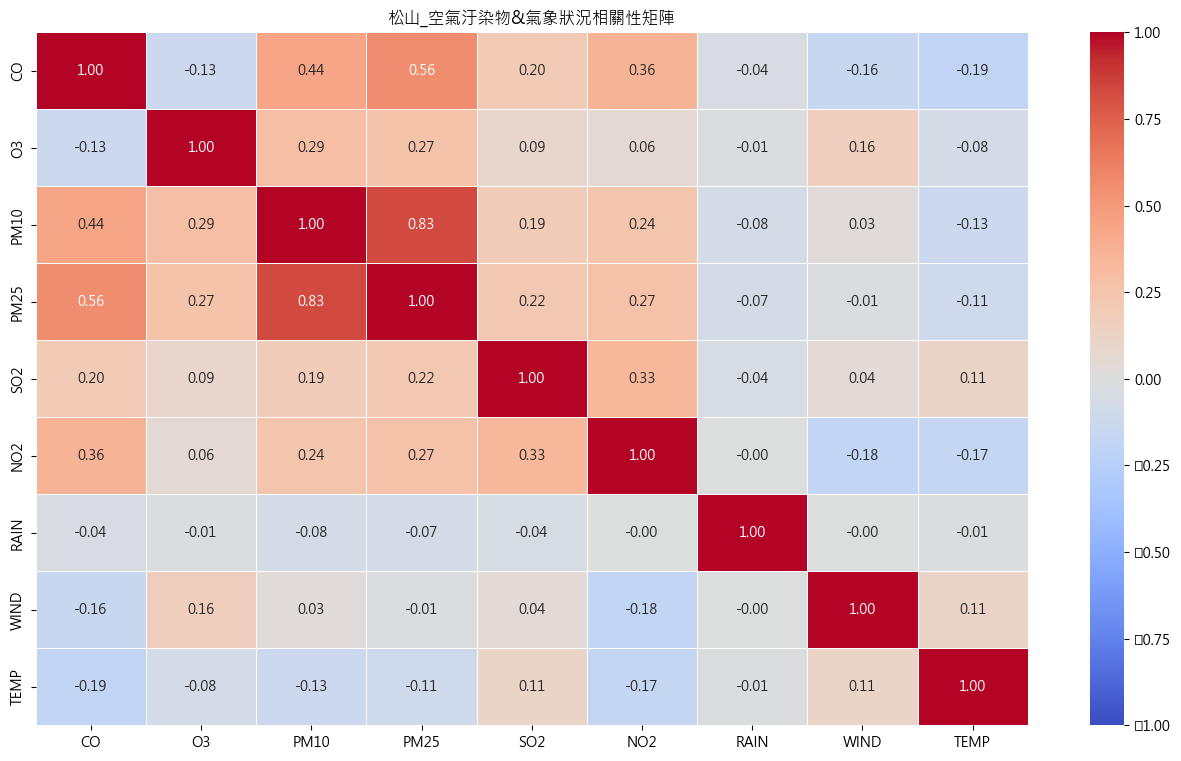

In [301]:
import seaborn as sns
Songshan_co = AQI_dict["Songshan_df_CO"]
co_Songshan = []
Songshan_o3 = AQI_dict["Songshan_df_O3"]
o3_Songshan = []
Songshan_no2 = AQI_dict["Songshan_df_NO2"]
no2_Songshan = []
Songshan_so2 = AQI_dict["Songshan_df_SO2"]
so2_Songshan = []
Songshan_pm25 = AQI_dict["Songshan_df_PM25"]
pm25_Songshan = []
Songshan_pm10 = AQI_dict["Songshan_df_PM10"]
pm10_Songshan = []
Songshan_temp = AQI_dict["Songshan_df_temp"]
temp_Songshan = []
Songshan_wind = AQI_dict["Songshan_df_wind"]
wind_Songshan = []
Songshan_rain = AQI_dict["Songshan_df_rain"]
rain_Songshan = []
Songshan_date = set(Songshan_pm25.keys())&set(Songshan_rain.keys())&set(Songshan_pm10.keys())&set(Songshan_o3.keys())&set(Songshan_so2.keys())&set(Songshan_no2.keys())&set(Songshan_co.keys())&set(Songshan_wind.keys())&set(Songshan_rain.keys())
Songshan_date = sorted(list(Songshan_date))
for w1 in range(len(Songshan_date)):
    for w2 in range(len(Songshan_co[Songshan_date[w1]])):
        co_Songshan.append(Songshan_co[Songshan_date[w1]][w2])
    for w3 in range(len(Songshan_o3[Songshan_date[w1]])):
        o3_Songshan.append(Songshan_o3[Songshan_date[w1]][w3])
    for w4 in range(len(Songshan_pm25[Songshan_date[w1]])):
        pm25_Songshan.append(Songshan_pm25[Songshan_date[w1]][w4])
    for w5 in range(len(Songshan_pm10[Songshan_date[w1]])):
        pm10_Songshan.append(Songshan_pm10[Songshan_date[w1]][w5])
    for w6 in range(len(Songshan_so2[Songshan_date[w1]])):
        so2_Songshan.append(Songshan_so2[Songshan_date[w1]][w6])
    for w7 in range(len(Songshan_no2[Songshan_date[w1]])):
        no2_Songshan.append(Songshan_no2[Songshan_date[w1]][w7])
    for w8 in range(len(Songshan_temp[Songshan_date[w1]])):
        temp_Songshan.append(Songshan_temp[Songshan_date[w1]][w8])
    for w9 in range(len(Songshan_rain[Songshan_date[w1]])):
        rain_Songshan.append(Songshan_rain[Songshan_date[w1]][w9])
    for w10 in range(len(Songshan_wind[Songshan_date[w1]])):
        wind_Songshan.append(Songshan_wind[Songshan_date[w1]][w10])
Songshan_all = {"CO":co_Songshan,"O3":o3_Songshan,"PM10":pm10_Songshan,"PM25":pm25_Songshan,"NO2":no2_Songshan,"SO2":so2_Songshan,"TEMP":temp_Songshan,"RAIN":rain_Songshan,"WIND":wind_Songshan}
Songshan_all_df = pd.DataFrame(Songshan_all)
Songshan_pollutants = ['CO','O3','PM10','PM25','SO2','NO2']
Songshan_weather_variables = ['RAIN','WIND','TEMP']
Songshan_selected_columns = Songshan_pollutants + Songshan_weather_variables
Songshan_sub_df = Songshan_all_df[Songshan_selected_columns]
correlation_matrix = Songshan_sub_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('松山_空氣汙染物&氣象狀況相關性矩陣')
plt.show()

In [129]:
def Times_count(name):
    Time_Data = []
    Data_co_time = list(AQI_dict["{}_df_CO".format(name)].keys())
    Data_o3_time = list(AQI_dict["{}_df_O3".format(name)].keys())
    Data_pm10_time = list(AQI_dict["{}_df_PM10".format(name)].keys())
    Data_pm25_time = list(AQI_dict["{}_df_PM25".format(name)].keys())
    Data_so2_time = list(AQI_dict["{}_df_SO2".format(name)].keys())
    Data_no2_time = list(AQI_dict["{}_df_NO2".format(name)].keys())
    Time_Data = Data_co_time + Data_no2_time + Data_o3_time + Data_pm10_time + Data_pm25_time + Data_so2_time
    new_Time_Data = sorted(list(set(Time_Data)))
    All_Data = {}
    for s1 in range(len(new_Time_Data)):
        s2 = new_Time_Data[s1]
        Data_so2 = max(AQI_dict["{}_df_SO2".format(name)][s2])
        Data_co = max(AQI_dict["{}_df_CO".format(name)][s2])
        Data_pm10 = max(AQI_dict["{}_df_PM10".format(name)][s2])
        Data_pm25 = max(AQI_dict["{}_df_PM25".format(name)][s2])
        try:
            Data_o3 = max(AQI_dict["{}_df_O3".format(name)][s2])
        except:
            Data_o3 = 0
        Data_no2 = max(AQI_dict["{}_df_NO2".format(name)][s2])
        s3 = [Data_co,Data_no2,Data_pm25,Data_pm10,Data_so2,Data_o3]
        max_s3 = np.nanmax(s3)
        if max_s3 == Data_co:
            All_Data[s2] = ["CO",max_s3]
        elif max_s3 == Data_no2:
            All_Data[s2] = ["NO2",max_s3]
        elif max_s3 == Data_pm25:
            All_Data[s2] = ["PM25",max_s3]
        elif max_s3 == Data_pm10:
            All_Data[s2] = ["PM10",max_s3]
        elif max_s3 == Data_so2:
            All_Data[s2] = ["SO2",max_s3]
        elif max_s3 == Data_o3:
            All_Data[s2] = ["O3",max_s3]
    return All_Data

In [131]:
Daton_AQI_By_Year = Times_count("Daton")
Shilin_AQI_By_Year = Times_count("Shilin")
Yangming_AQI_By_Year = Times_count("Yangming")
Zhongshan_AQI_By_Year = Times_count("Zhongshan")
Songshan_AQI_By_Year = Times_count("Songshan")
Wanhua_AQI_By_Year = Times_count("Wanhua")
Gutin_AQI_By_Year = Times_count("Gutin")

In [156]:
count_daton_2018 = 0
count_daton_2019 = 0
count_daton_2020 = 0
count_daton_2021 = 0
count_daton_2022 = 0

for key7 in Daton_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Daton_AQI_By_Year[key7][1] >= 100:
            count_daton_2018+=1
    elif key7[0:4] == "2019":
        if Daton_AQI_By_Year[key7][1] >= 100:
            count_daton_2019+=1
    elif key7[0:4] == "2020":
        if Daton_AQI_By_Year[key7][1] >= 100:
            count_daton_2020+=1
    elif key7[0:4] == "2021":
        if Daton_AQI_By_Year[key7][1] >= 100:
            count_daton_2021+=1
    elif key7[0:4] == "2022":
        if Daton_AQI_By_Year[key7][1] >= 100:
            count_daton_2022+=1
count_daton_list = [count_daton_2018,count_daton_2019,count_daton_2020,count_daton_2021,count_daton_2022]

[34, 19, 18, 30, 10]

In [157]:
count_Gutin_2018 = 0
count_Gutin_2019 = 0
count_Gutin_2020 = 0
count_Gutin_2021 = 0
count_Gutin_2022 = 0


for key7 in Gutin_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Gutin_AQI_By_Year[key7][1] >= 100:
            count_Gutin_2018+=1
    elif key7[0:4] == "2019":
        if Gutin_AQI_By_Year[key7][1] >= 100:
            count_Gutin_2019+=1
    elif key7[0:4] == "2020":
        if Gutin_AQI_By_Year[key7][1] >= 100:
            count_Gutin_2020+=1
    elif key7[0:4] == "2021":
        if Gutin_AQI_By_Year[key7][1] >= 100:
            count_Gutin_2021+=1
    elif key7[0:4] == "2022":
        if Gutin_AQI_By_Year[key7][1] >= 100:
            count_Gutin_2022+=1
count_Gutin_list = [count_Gutin_2018,count_Gutin_2019,count_Gutin_2020,count_Gutin_2021,count_Gutin_2022]
count_Gutin_list

[36, 44, 23, 28, 16]

In [158]:
count_Wanhua_2018 = 0
count_Wanhua_2019 = 0
count_Wanhua_2020 = 0
count_Wanhua_2021 = 0
count_Wanhua_2022 = 0


for key7 in Wanhua_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Wanhua_AQI_By_Year[key7][1] >= 100:
            count_Wanhua_2018+=1
    elif key7[0:4] == "2019":
        if Wanhua_AQI_By_Year[key7][1] >= 100:
            count_Wanhua_2019+=1
    elif key7[0:4] == "2020":
        if Wanhua_AQI_By_Year[key7][1] >= 100:
            count_Wanhua_2020+=1
    elif key7[0:4] == "2021":
        if Wanhua_AQI_By_Year[key7][1] >= 100:
            count_Wanhua_2021+=1
    elif key7[0:4] == "2022":
        if Wanhua_AQI_By_Year[key7][1] >= 100:
            count_Wanhua_2022+=1
count_Wanhua_list = [count_Wanhua_2018,count_Wanhua_2019,count_Wanhua_2020,count_Wanhua_2021,count_Wanhua_2022]
count_Wanhua_list

[43, 25, 11, 29, 13]

In [159]:
count_Songshan_2018 = 0
count_Songshan_2019 = 0
count_Songshan_2020 = 0
count_Songshan_2021 = 0
count_Songshan_2022 = 0


for key7 in Songshan_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Songshan_AQI_By_Year[key7][1] >= 100:
            count_Songshan_2018+=1
    elif key7[0:4] == "2019":
        if Songshan_AQI_By_Year[key7][1] >= 100:
            count_Songshan_2019+=1
    elif key7[0:4] == "2020":
        if Songshan_AQI_By_Year[key7][1] >= 100:
            count_Songshan_2020+=1
    elif key7[0:4] == "2021":
        if Songshan_AQI_By_Year[key7][1] >= 100:
            count_Songshan_2021+=1
    elif key7[0:4] == "2022":
        if Songshan_AQI_By_Year[key7][1] >= 100:
            count_Songshan_2022+=1
count_Songshan_list = [count_Songshan_2018,count_Songshan_2019,count_Songshan_2020,count_Songshan_2021,count_Songshan_2022]
count_Songshan_list

[37, 24, 26, 25, 14]

In [160]:
count_Zhongshan_2018 = 0
count_Zhongshan_2019 = 0
count_Zhongshan_2020 = 0
count_Zhongshan_2021 = 0
count_Zhongshan_2022 = 0


for key7 in Zhongshan_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Zhongshan_AQI_By_Year[key7][1] >= 100:
            count_Zhongshan_2018+=1
    elif key7[0:4] == "2019":
        if Zhongshan_AQI_By_Year[key7][1] >= 100:
            count_Zhongshan_2019+=1
    elif key7[0:4] == "2020":
        if Zhongshan_AQI_By_Year[key7][1] >= 100:
            count_Zhongshan_2020+=1
    elif key7[0:4] == "2021":
        if Zhongshan_AQI_By_Year[key7][1] >= 100:
            count_Zhongshan_2021+=1
    elif key7[0:4] == "2022":
        if Zhongshan_AQI_By_Year[key7][1] >= 100:
            count_Zhongshan_2022+=1
count_Zhongshan_list = [count_Zhongshan_2018,count_Zhongshan_2019,count_Zhongshan_2020,count_Zhongshan_2021,count_Zhongshan_2022]
count_Zhongshan_list

[40, 22, 22, 28, 10]

In [161]:
count_Yangming_2018 = 0
count_Yangming_2019 = 0
count_Yangming_2020 = 0
count_Yangming_2021 = 0
count_Yangming_2022 = 0


for key7 in Yangming_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Yangming_AQI_By_Year[key7][1] >= 100:
            count_Yangming_2018+=1
    elif key7[0:4] == "2019":
        if Yangming_AQI_By_Year[key7][1] >= 100:
            count_Yangming_2019+=1
    elif key7[0:4] == "2020":
        if Yangming_AQI_By_Year[key7][1] >= 100:
            count_Yangming_2020+=1
    elif key7[0:4] == "2021":
        if Yangming_AQI_By_Year[key7][1] >= 100:
            count_Yangming_2021+=1
    elif key7[0:4] == "2022":
        if Yangming_AQI_By_Year[key7][1] >= 100:
            count_Yangming_2022+=1
count_Yangming_list = [count_Yangming_2018,count_Yangming_2019,count_Yangming_2020,count_Yangming_2021,count_Yangming_2022]
count_Yangming_list

[20, 14, 18, 16, 12]

In [163]:
count_Shilin_2018 = 0
count_Shilin_2019 = 0
count_Shilin_2020 = 0
count_Shilin_2021 = 0
count_Shilin_2022 = 0


for key7 in Shilin_AQI_By_Year.keys():
    if key7[0:4] == "2018":
        if Shilin_AQI_By_Year[key7][1] >= 100:
            count_Shilin_2018+=1
    elif key7[0:4] == "2019":
        if Shilin_AQI_By_Year[key7][1] >= 100:
            count_Shilin_2019+=1
    elif key7[0:4] == "2020":
        if Shilin_AQI_By_Year[key7][1] >= 100:
            count_Shilin_2020+=1
    elif key7[0:4] == "2021":
        if Shilin_AQI_By_Year[key7][1] >= 100:
            count_Shilin_2021+=1
    elif key7[0:4] == "2022":
        if Shilin_AQI_By_Year[key7][1] >= 100:
            count_Shilin_2022+=1
count_Shilin_list = [count_Shilin_2018,count_Shilin_2019,count_Shilin_2020,count_Shilin_2021,count_Shilin_2022]
count_Shilin_list

[50, 39, 25, 28, 16]

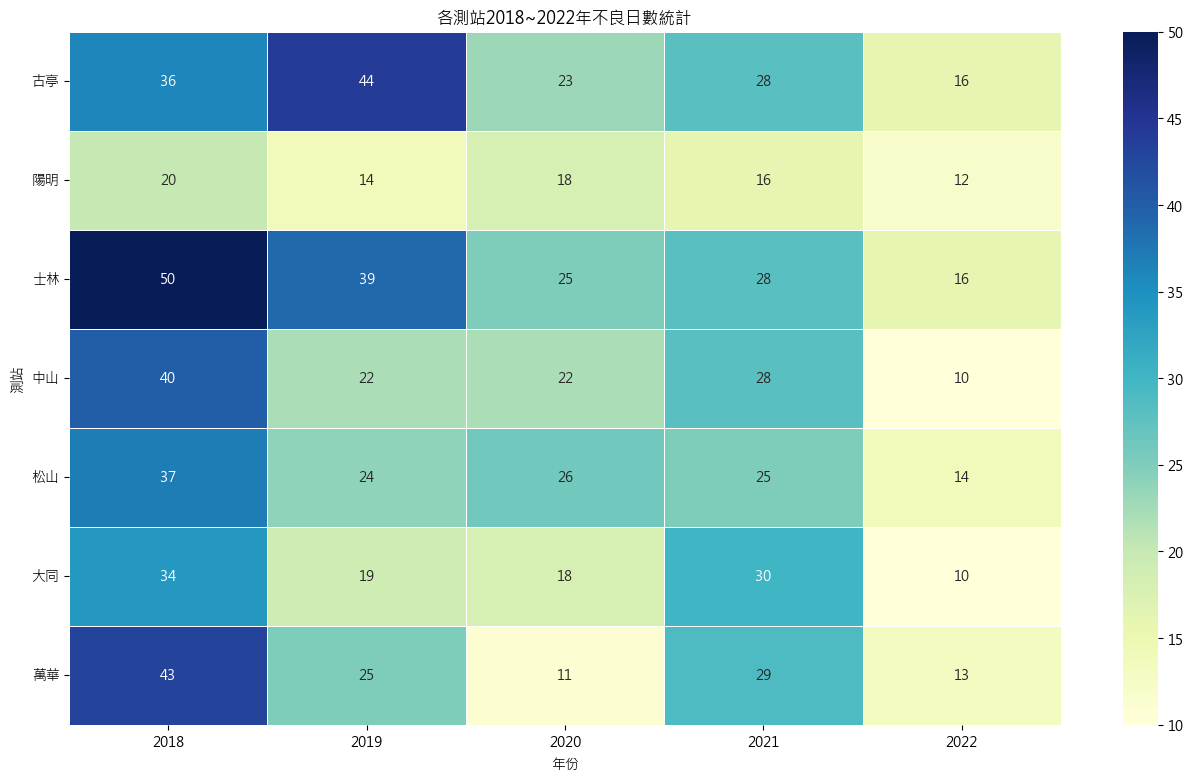

In [235]:
import seaborn as sns

Years = [2018,2019,2020,2021,2022]
AQI_ALL = pd.DataFrame({"古亭":count_Gutin_list,"陽明":count_Yangming_list,"士林":count_Shilin_list,"中山":count_Zhongshan_list,"松山":count_Songshan_list,"大同":count_daton_list,"萬華":count_Wanhua_list})
AQI_ALL_T = AQI_ALL.T
plt.figure(figsize=(16, 9))
plt.rc('font', family='Microsoft JhengHei')
sns.heatmap(AQI_ALL_T, annot=True, fmt="d", cmap="YlGnBu", xticklabels=Years, yticklabels=AQI_ALL_T.index, linewidths=.5)
plt.title('各測站2018~2022年不良日數統計')
plt.xlabel('年份')
plt.ylabel('測站')
plt.yticks(rotation='horizontal')
plt.show()

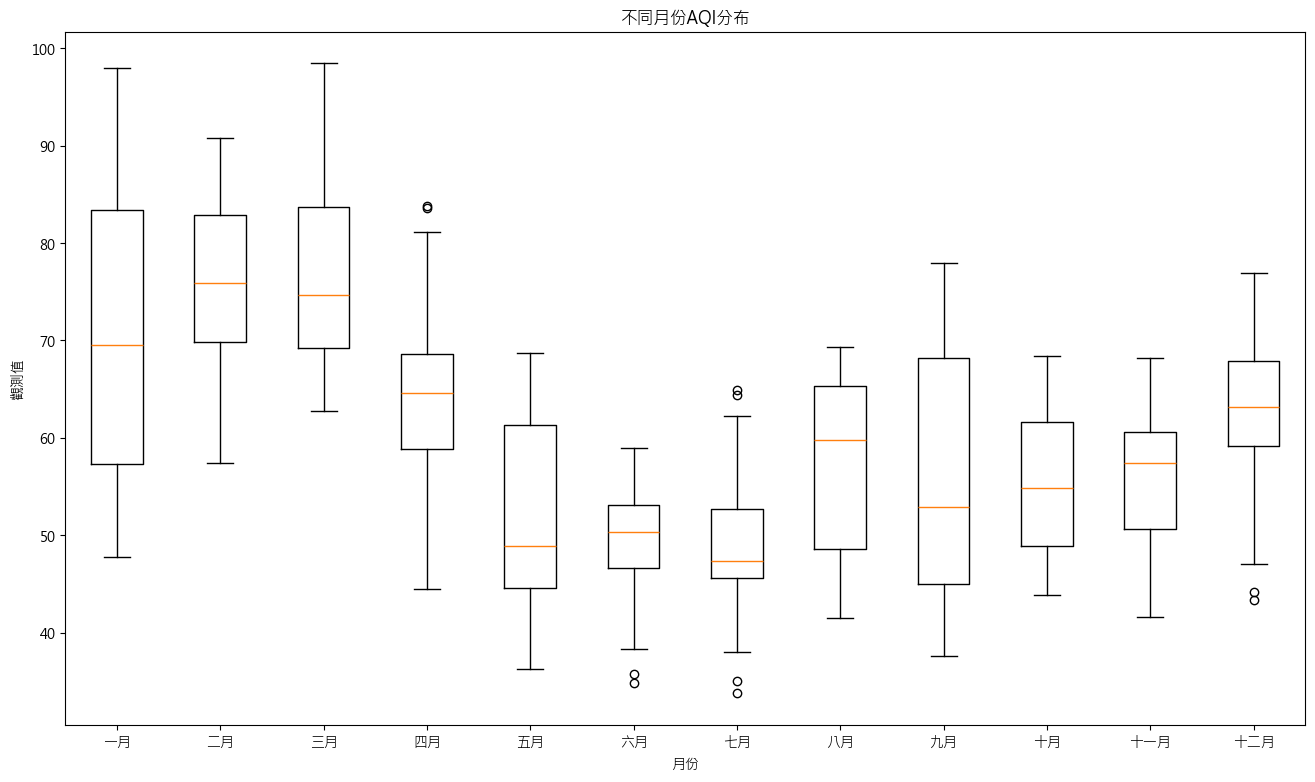

In [366]:
first = [62.803548387096775, 86.95760204081635, 80.69402457757297, 92.23366666666665, 81.1706912442396, 68.66328571428572, 52.74795698924731, 64.91331797235023, 69.31387301587303, 69.36545314900154, 62.89749206349207, 57.5131182795699, 66.97923195084485, 69.5021598639456, 78.73978494623655, 81.08666666666667, 61.99241167434716, 61.49184126984127, 51.88850998463902, 46.19013824884793, 45.99357142857143, 67.62898617511519, 60.79066666666665, 60.151182795698936, 69.28563748079878, 66.93399014778325, 70.34597542242703, 69.26114285714284, 61.07090629800307, 46.9353492063492, 50.1726420890937, 45.94800307219662, 63.637571428571434, 47.74881720430107, 52.6141746031746, 58.21718894009217, 63.188233486943155, 84.38872448979592, 83.5363594470046, 70.25915873015873, 62.41849462365593, 45.138984126984134, 46.33264208909372, 49.450768049155144, 46.6759365079365, 43.222427035330256, 54.692825396825405, 60.99758832565286, 60.84147465437787, 54.19717687074831, 71.07534562211983, 66.48904761904761, 47.25867895545316, 45.84952380952382, 48.07877112135177, 45.379953917050685, 56.532999999999994, 47.12886328725038, 47.80680952380953, 52.00984639016898]
second = [68.17221198156683, 93.36709183673467, 85.75566820276497, 94.67028571428573, 78.44073732718894, 66.31366666666666, 54.253824884792614, 62.22159754224271, 65.69461904761906, 68.93516129032257, 66.35790476190478, 64.8716129032258, 70.30838709677421, 71.7067857142857, 81.25926267281106, 77.01519047619048, 68.30972350230417, 64.82557142857142, 58.92394777265745, 52.7094777265745, 56.300777777777775, 75.77483870967744, 68.37946031746031, 68.15433179723503, 76.96709677419355, 76.38137931034483, 74.9990741516548, 72.988, 68.49345622119817, 56.865809523809524, 56.885176651305684, 52.60032258064515, 66.28087301587303, 59.769554531490016, 65.25901587301585, 67.91230414746545, 71.57603686635946, 88.34923469387753, 89.08672811059907, 71.47973015873013, 64.87701996927802, 48.87620634920635, 47.31043010752689, 57.85803379416281, 55.79731746031745, 54.96572964669739, 62.19442857142857, 67.54539170506912, 67.62884792626728, 62.31566326530613, 78.34682027649768, 70.88219047619047, 54.40101382488479, 53.204523809523806, 56.14055299539171, 55.17568356374809, 63.363809523809536, 55.70258064516129, 54.7985238095238, 58.870783410138266]
third = [43.355483870967745, 51.682857142857145, 62.213225806451625, 87.14066666666665, 68.58322580645161, 58.23933333333332, 34.80032258064516, 45.37354838709676, 54.901, 77.91096774193551, 46.34333333333333, 44.60774193548388, 47.04354838709677, 47.84000000000001, 68.98451612903227, 71.28733333333334, 64.90709677419355, 44.45333333333334, 39.13580645161292, 35.027741935483874, 42.617666666666665, 61.5241935483871, 51.86233333333334, 43.94548387096774, 44.16516129032259, 48.92689655172414, 61.71096774193549, 82.23533333333336, 53.43935483870967, 38.00966666666667, 35.79161290322581, 33.76645161290322, 59.864999999999995, 47.72838709677419, 47.932, 41.59290322580646, 48.86096774193549, 68.77642857142855, 57.44548387096774, 72.80966666666667, 56.64096774193549, 39.76066666666666, 38.29548387096775, 40.18741935483871, 41.45099999999999, 42.42645161290323, 56.35500000000001, 49.942903225806454, 52.969354838709684, 47.80000000000001, 63.516129032258064, 64.04566666666668, 46.778387096774196, 36.27733333333333, 41.98000000000001, 43.47967741935484, 67.53666666666668, 45.52935483870967, 43.86148148148148, 43.30483870967742]
fourth = [58.99617511520737, 68.38112244897958, 64.3379416282642, 85.1142857142857, 79.21760368663594, 65.5242380952381, 52.60663594470046, 64.40623655913978, 65.8407142857143, 71.05379416282642, 66.57569841269842, 64.97602150537635, 71.71079877112136, 70.79292517006802, 90.76737327188941, 91.08300000000001, 68.62096774193549, 48.29435626102292, 52.1858064516129, 42.233625192012305, 53.455142857142846, 64.70096774193549, 58.14933333333333, 60.49960061443931, 63.36196620583716, 62.81315270935959, 70.0121658986175, 76.13944444444444, 66.61410138248849, 55.10933333333333, 51.8963440860215, 47.628525345622116, 67.34223809523809, 45.715591397849444, 45.248666666666665, 52.271996927803386, 59.257066052227344, 83.0472619047619, 81.30686635944701, 68.84273015873016, 63.95182795698925, 44.49744444444444, 47.17279569892473, 50.81033794162827, 45.177555555555564, 37.54451612903227, 49.91809523809525, 55.20135176651306, 58.738955453148996, 50.55098639455783, 68.15247311827956, 64.0082380952381, 44.49038402457757, 42.716619047619034, 53.25910906298002, 50.77278033794163, 62.401666666666664, 43.45695852534562, 46.049301587301585, 46.11284178187403]
fifth = [63.97972350230416, 84.89744897959183, 75.8979416282642, 88.09700000000001, 83.8322119815668, 65.12787301587302, 52.068156682027656, 59.16158218125959, 65.01179365079365, 67.38242703533027, 61.98096825396826, 57.37436251920124, 67.32228878648233, 67.87925170068027, 82.28118279569892, 82.22033333333333, 65.10760368663595, 60.560777777777794, 53.896190476190476, 46.3826728110599, 47.6014761904762, 68.69015360983103, 61.27001587301587, 59.177096774193544, 69.85245775729648, 71.09724137931035, 73.32353302611367, 77.00750793650795, 66.87600614439324, 50.72952380952381, 50.765468509984636, 45.918448540706606, 66.63722222222222, 49.75566820276498, 52.3115238095238, 56.11628264208909, 61.31222734254993, 83.66193877551017, 84.67709677419356, 68.41126984126984, 69.32978494623656, 44.551174603174594, 48.1447311827957, 49.00244239631337, 44.553158730158735, 40.71394777265745, 54.814603174603164, 59.038387096774194, 59.33866359447005, 51.83913265306121, 69.62192012288784, 65.17755555555556, 45.41056835637481, 44.982873015873004, 55.2725806451613, 47.782411674347166, 59.78465079365079, 41.603133640553, 45.8013492063492, 50.59712749615975]
sixth = [62.78, 97.97193877551021, 83.60150537634408, 93.13971428571428, 83.63870967741936, 61.2270634920635, 52.88053763440861, 59.93064516129033, 66.61726984126985, 65.06261136712749, 64.60742857142856, 62.53622119815669, 70.86774193548388, 73.11605442176871, 83.54242703533028, 81.19780952380951, 64.6005529953917, 61.29026984126983, 55.61565284178186, 47.36267281105991, 49.554, 69.00299539170508, 61.5797619047619, 62.3389247311828, 72.0173732718894, 70.85272577996714, 73.84370199692782, 69.93338095238096, 64.31076804915513, 48.90566666666667, 49.4578494623656, 46.984685099846395, 64.06450793650794, 51.27012288786483, 53.06096825396825, 58.551505376344075, 63.97233486943165, 85.04268707482994, 85.432534562212, 69.19953968253968, 63.16215053763442, 44.34184126984126, 46.20847926267281, 50.44675883256528, 47.454, 43.59815668202764, 56.021095238095235, 60.75669738863287, 62.42079877112135, 53.82806122448981, 70.8053456221198, 62.77390476190477, 45.44239631336406, 44.90249206349207, 46.814101382488474, 44.09717357910906, 53.72211111111111, 46.45003072196621, 47.57869841269841, 51.64072196620585]
seventh = [52.98161290322581, 84.66471088435374, 80.23631336405528, 98.45766666666667, 77.85225806451614, 67.98061904761904, 50.31007680491552, 60.667726574500776, 69.20180952380952, 77.00127496159755, 57.42598412698414, 56.87728110599079, 63.64634408602152, 60.40727891156463, 87.88935483870969, 87.32966666666665, 77.19967741935486, 64.78285714285715, 55.54196620583716, 45.95743471582182, 51.97244444444444, 72.56382488479262, 61.698761904761916, 52.971290322580636, 63.675821812596006, 65.10940886699508, 71.37488479262673, 81.78171428571429, 61.08397849462366, 44.686301587301585, 46.41185867895544, 46.55589861751152, 64.9518253968254, 52.87645161290322, 52.39333333333334, 50.646543778801835, 59.32175115207375, 82.65976190476191, 81.7131797235023, 74.68566666666666, 61.32387096774193, 45.72396825396826, 49.32769585253455, 46.98651305683565, 44.42990476190476, 41.49195084485406, 50.94080952380952, 50.70827956989248, 56.03029185867895, 50.454234693877545, 67.07711213517666, 63.33361904761905, 45.38680491551458, 41.82603174603174, 43.33920122887864, 37.95198156682028, 61.861555555555555, 44.45537634408601, 44.66534920634921, 45.014792626728116]
all_data = [first,second,third,fourth,fifth,sixth,seventh]
jan = []
feb = []
mar = []
apr = []
may = []
jun = []
jul = []
aug = []
sep = []
oct = []
nov = []
dec = []
month = [jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]
for j1 in range(len(first)):
    if j1%12 == 1:
        for j2 in range(len(all_data)):
            month[0].append(all_data[j2][j1])
    elif j1%12 == 2:
        for j2 in range(len(all_data)):
            month[1].append(all_data[j2][j1])
    elif j1%12 == 3:
        for j2 in range(len(all_data)):
            month[2].append(all_data[j2][j1])
    elif j1%12 == 4:
        for j2 in range(len(all_data)):
            month[3].append(all_data[j2][j1])
    elif j1%12 == 5:
        for j2 in range(len(all_data)):
            month[4].append(all_data[j2][j1])
    elif j1%12 == 6:
        for j2 in range(len(all_data)):
            month[5].append(all_data[j2][j1])
    elif j1%12 == 7:
        for j2 in range(len(all_data)):
            month[6].append(all_data[j2][j1])
    elif j1%12 == 8:
        for j2 in range(len(all_data)):
            month[7].append(all_data[j2][j1])
    elif j1%12 == 9:
        for j2 in range(len(all_data)):
            month[8].append(all_data[j2][j1])
    elif j1%12 == 10:
        for j2 in range(len(all_data)):
            month[9].append(all_data[j2][j1])
    elif j1%12 == 11:
        for j2 in range(len(all_data)):
            month[10].append(all_data[j2][j1])
    elif j1%12 == 0:
        for j2 in range(len(all_data)):
            month[11].append(all_data[j2][j1])
plt.figure(figsize=(16, 9))
plt.boxplot(month,labels=['一月','二月','三月','四月','五月','六月','七月','八月','九月','十月','十一月','十二月'])
plt.title('不同月份AQI分布')
plt.xlabel('月份')
plt.ylabel('觀測值')
plt.show()

47.31043010752689
56.88033486943164
66.29726984126984
71.60872407834103
94.67028571428573
66.48119134820543


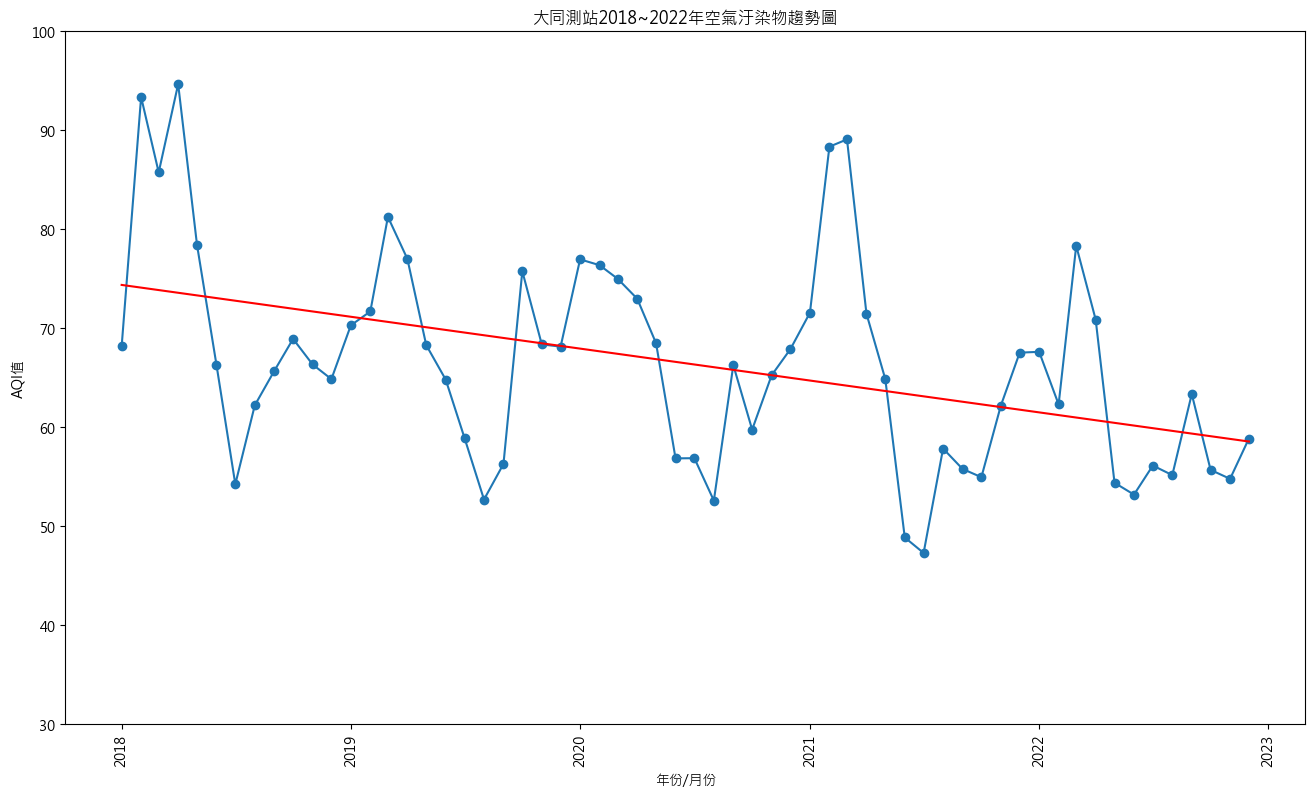

[68.17221198156683, 93.36709183673467, 85.75566820276497, 94.67028571428573, 78.44073732718894, 66.31366666666666, 54.253824884792614, 62.22159754224271, 65.69461904761906, 68.93516129032257, 66.35790476190478, 64.8716129032258, 70.30838709677421, 71.7067857142857, 81.25926267281106, 77.01519047619048, 68.30972350230417, 64.82557142857142, 58.92394777265745, 52.7094777265745, 56.300777777777775, 75.77483870967744, 68.37946031746031, 68.15433179723503, 76.96709677419355, 76.38137931034483, 74.9990741516548, 72.988, 68.49345622119817, 56.865809523809524, 56.885176651305684, 52.60032258064515, 66.28087301587303, 59.769554531490016, 65.25901587301585, 67.91230414746545, 71.57603686635946, 88.34923469387753, 89.08672811059907, 71.47973015873013, 64.87701996927802, 48.87620634920635, 47.31043010752689, 57.85803379416281, 55.79731746031745, 54.96572964669739, 62.19442857142857, 67.54539170506912, 67.62884792626728, 62.31566326530613, 78.34682027649768, 70.88219047619047, 54.40101382488479, 53

In [342]:
import matplotlib.dates as mdates
from datetime import datetime
import pytz

daton_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Daton_AQI_By_Year.keys():
    if [key8][0:7] not in list(daton_month_trend.keys()):
        daton_month_trend[key8[0:7]] = [0,0]
for key9 in daton_month_trend.keys():
    for key8 in Daton_AQI_By_Year.keys():
        if key8[0:7] == key9:
            daton_month_trend[key8[0:7]][0] += Daton_AQI_By_Year[key8][1]
            daton_month_trend[key8[0:7]][1] += 1
for key10 in daton_month_trend.keys():  
    daton_month_trend[key10] = daton_month_trend[key10][0]/daton_month_trend[key10][1]        
daton_month_trend
oo_list = []
for oo in daton_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))

tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('大同測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

43.222427035330256
49.1077688172043
61.03424731182797
69.26726651305682
92.23366666666665
60.947186910016754


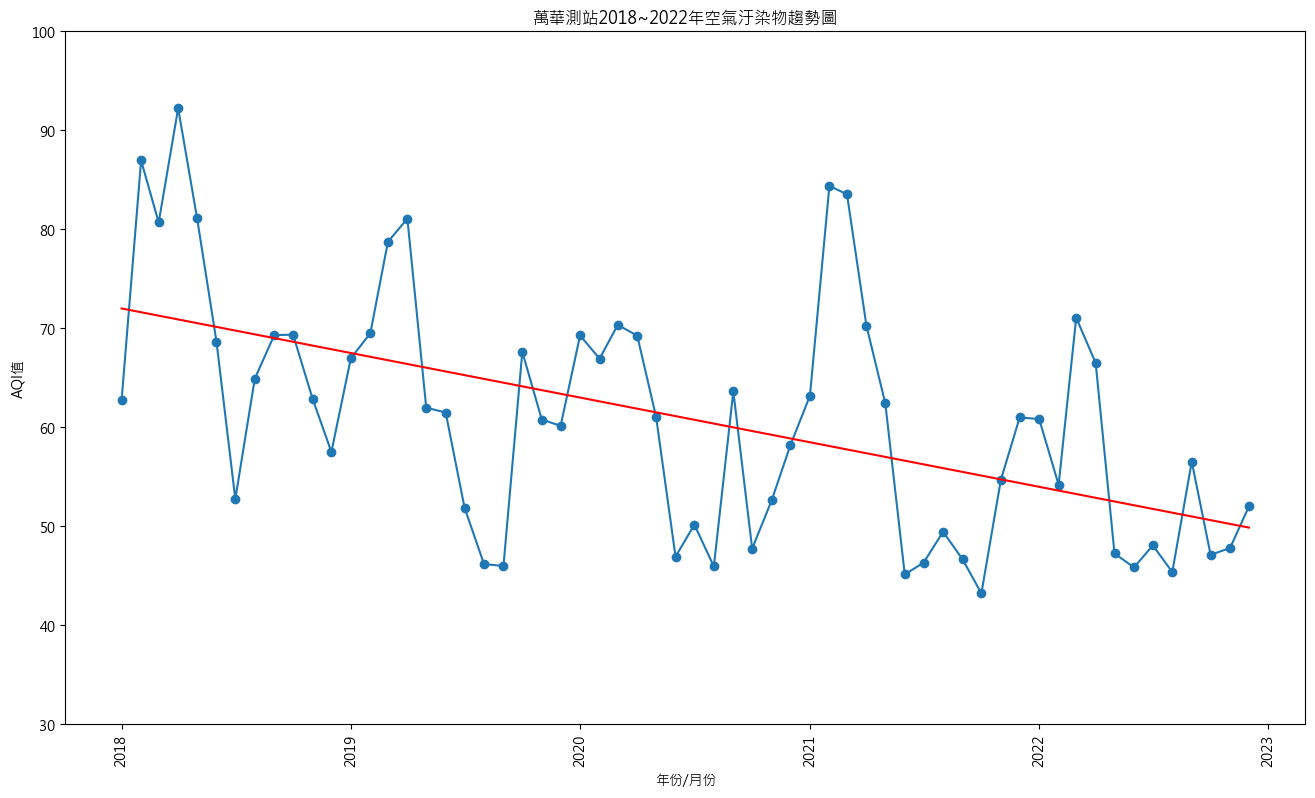

[62.803548387096775, 86.95760204081635, 80.69402457757297, 92.23366666666665, 81.1706912442396, 68.66328571428572, 52.74795698924731, 64.91331797235023, 69.31387301587303, 69.36545314900154, 62.89749206349207, 57.5131182795699, 66.97923195084485, 69.5021598639456, 78.73978494623655, 81.08666666666667, 61.99241167434716, 61.49184126984127, 51.88850998463902, 46.19013824884793, 45.99357142857143, 67.62898617511519, 60.79066666666665, 60.151182795698936, 69.28563748079878, 66.93399014778325, 70.34597542242703, 69.26114285714284, 61.07090629800307, 46.9353492063492, 50.1726420890937, 45.94800307219662, 63.637571428571434, 47.74881720430107, 52.6141746031746, 58.21718894009217, 63.188233486943155, 84.38872448979592, 83.5363594470046, 70.25915873015873, 62.41849462365593, 45.138984126984134, 46.33264208909372, 49.450768049155144, 46.6759365079365, 43.222427035330256, 54.692825396825405, 60.99758832565286, 60.84147465437787, 54.19717687074831, 71.07534562211983, 66.48904761904761, 47.25867895

In [341]:
Wanhua_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Wanhua_AQI_By_Year.keys():
    if [key8][0:7] not in list(Wanhua_month_trend.keys()):
        Wanhua_month_trend[key8[0:7]] = [0,0]
for key9 in Wanhua_month_trend.keys():
    for key8 in Wanhua_AQI_By_Year.keys():
        if key8[0:7] == key9:
            Wanhua_month_trend[key8[0:7]][0] += Wanhua_AQI_By_Year[key8][1]
            Wanhua_month_trend[key8[0:7]][1] += 1
for key10 in Wanhua_month_trend.keys():  
    Wanhua_month_trend[key10] = Wanhua_month_trend[key10][0]/Wanhua_month_trend[key10][1]        
Wanhua_month_trend
oo_list = []
for oo in Wanhua_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))

tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('萬華測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

33.76645161290322
43.13304569892473
47.82000000000001
60.279798387096776
87.14066666666665
51.64959708396358


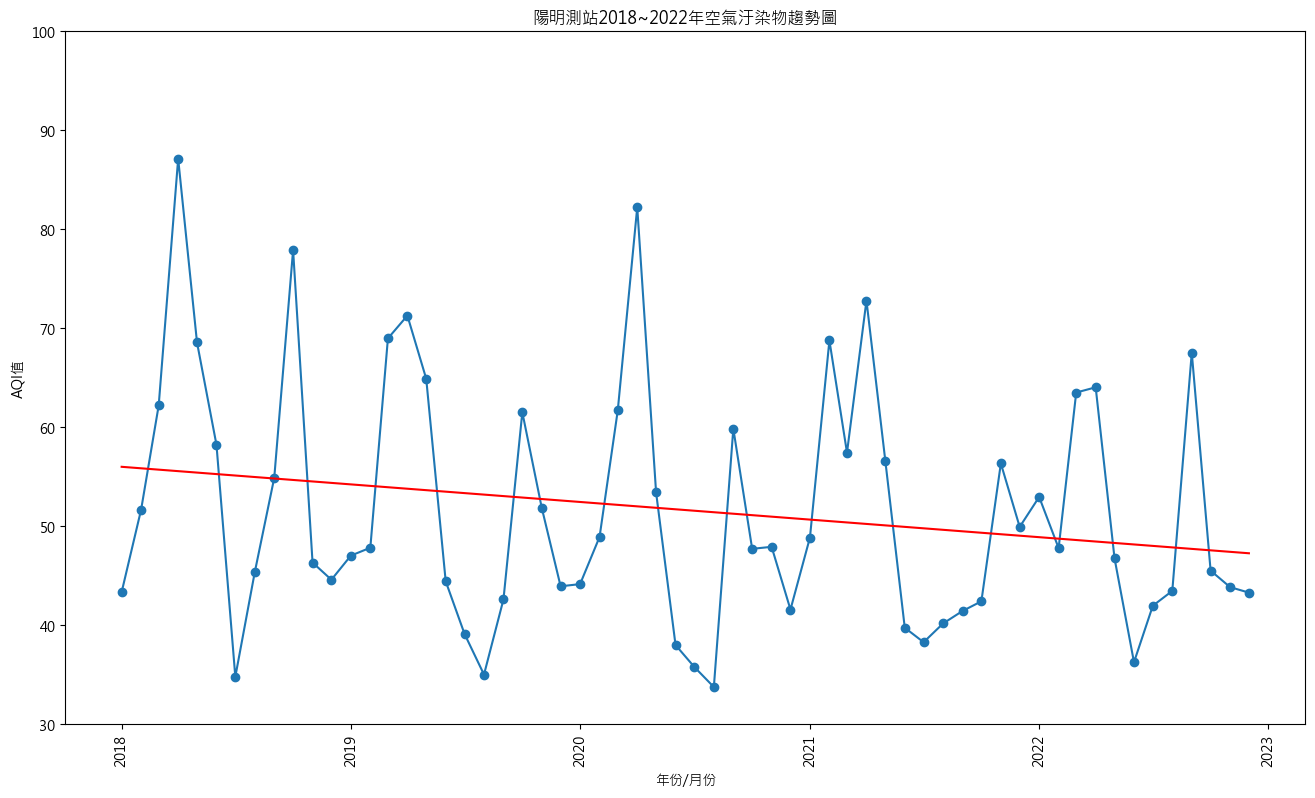

[43.355483870967745, 51.682857142857145, 62.213225806451625, 87.14066666666665, 68.58322580645161, 58.23933333333332, 34.80032258064516, 45.37354838709676, 54.901, 77.91096774193551, 46.34333333333333, 44.60774193548388, 47.04354838709677, 47.84000000000001, 68.98451612903227, 71.28733333333334, 64.90709677419355, 44.45333333333334, 39.13580645161292, 35.027741935483874, 42.617666666666665, 61.5241935483871, 51.86233333333334, 43.94548387096774, 44.16516129032259, 48.92689655172414, 61.71096774193549, 82.23533333333336, 53.43935483870967, 38.00966666666667, 35.79161290322581, 33.76645161290322, 59.864999999999995, 47.72838709677419, 47.932, 41.59290322580646, 48.86096774193549, 68.77642857142855, 57.44548387096774, 72.80966666666667, 56.64096774193549, 39.76066666666666, 38.29548387096775, 40.18741935483871, 41.45099999999999, 42.42645161290323, 56.35500000000001, 49.942903225806454, 52.969354838709684, 47.80000000000001, 63.516129032258064, 64.04566666666668, 46.778387096774196, 36.27

In [343]:
Yangming_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Yangming_AQI_By_Year.keys():
    if [key8][0:7] not in list(Yangming_month_trend.keys()):
        Yangming_month_trend[key8[0:7]] = [0,0]
for key9 in Yangming_month_trend.keys():
    for key8 in Yangming_AQI_By_Year.keys():
        if key8[0:7] == key9:
            Yangming_month_trend[key8[0:7]][0] += Yangming_AQI_By_Year[key8][1]
            Yangming_month_trend[key8[0:7]][1] += 1
for key10 in Yangming_month_trend.keys():  
    Yangming_month_trend[key10] = Yangming_month_trend[key10][0]/Yangming_month_trend[key10][1]        
Yangming_month_trend
oo_list = []
for oo in Yangming_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))
tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('陽明測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

37.54451612903227
50.392763605442184
59.87833333333333
67.54479685099845
91.08300000000001
60.018600912679034


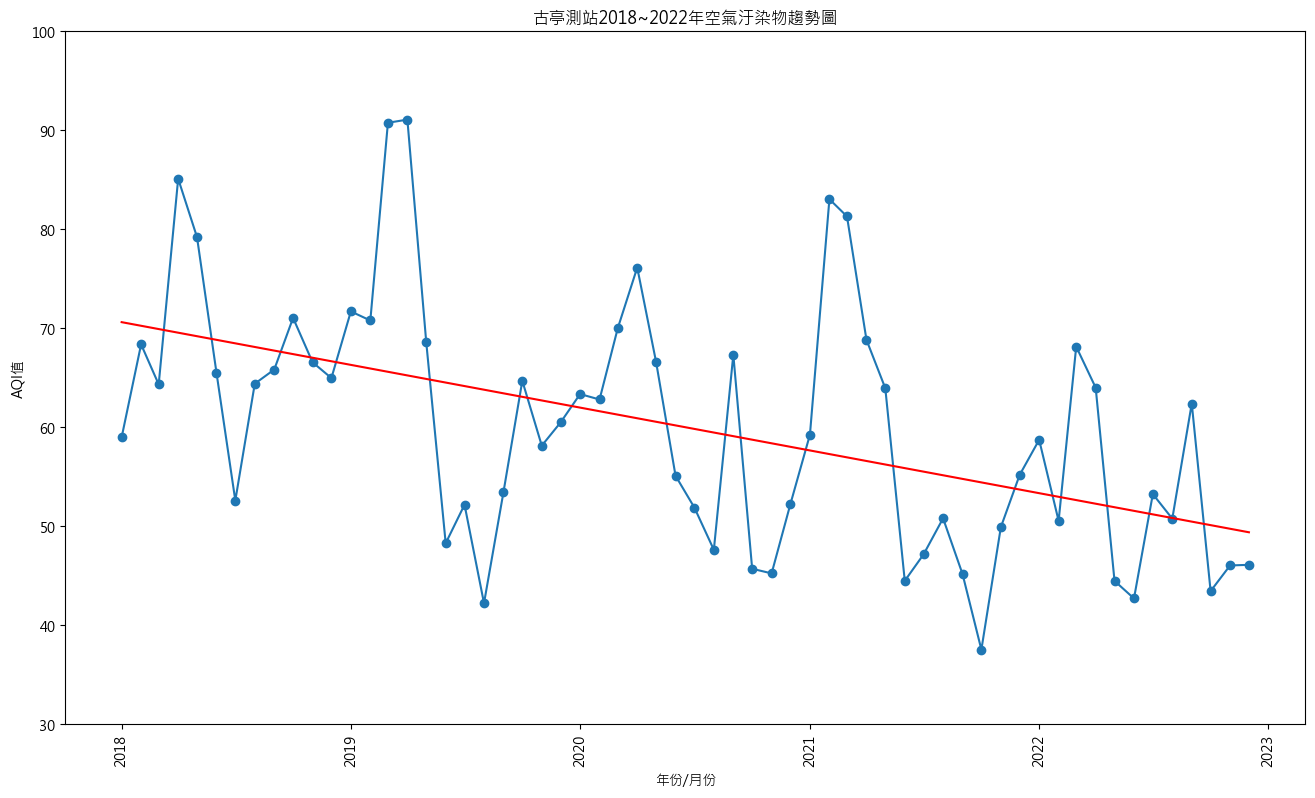

[58.99617511520737, 68.38112244897958, 64.3379416282642, 85.1142857142857, 79.21760368663594, 65.5242380952381, 52.60663594470046, 64.40623655913978, 65.8407142857143, 71.05379416282642, 66.57569841269842, 64.97602150537635, 71.71079877112136, 70.79292517006802, 90.76737327188941, 91.08300000000001, 68.62096774193549, 48.29435626102292, 52.1858064516129, 42.233625192012305, 53.455142857142846, 64.70096774193549, 58.14933333333333, 60.49960061443931, 63.36196620583716, 62.81315270935959, 70.0121658986175, 76.13944444444444, 66.61410138248849, 55.10933333333333, 51.8963440860215, 47.628525345622116, 67.34223809523809, 45.715591397849444, 45.248666666666665, 52.271996927803386, 59.257066052227344, 83.0472619047619, 81.30686635944701, 68.84273015873016, 63.95182795698925, 44.49744444444444, 47.17279569892473, 50.81033794162827, 45.177555555555564, 37.54451612903227, 49.91809523809525, 55.20135176651306, 58.738955453148996, 50.55098639455783, 68.15247311827956, 64.0082380952381, 44.49038402

In [344]:
Gutin_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Gutin_AQI_By_Year.keys():
    if [key8][0:7] not in list(Gutin_month_trend.keys()):
        Gutin_month_trend[key8[0:7]] = [0,0]
for key9 in Gutin_month_trend.keys():
    for key8 in Gutin_AQI_By_Year.keys():
        if key8[0:7] == key9:
            Gutin_month_trend[key8[0:7]][0] += Gutin_AQI_By_Year[key8][1]
            Gutin_month_trend[key8[0:7]][1] += 1
for key10 in Gutin_month_trend.keys():  
    Gutin_month_trend[key10] = Gutin_month_trend[key10][0]/Gutin_month_trend[key10][1]        
Gutin_month_trend
oo_list = []
for oo in Gutin_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))
tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('古亭測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

40.71394777265745
50.696424731182795
60.17271428571429
68.48099078341014
88.09700000000001
61.05023577694457


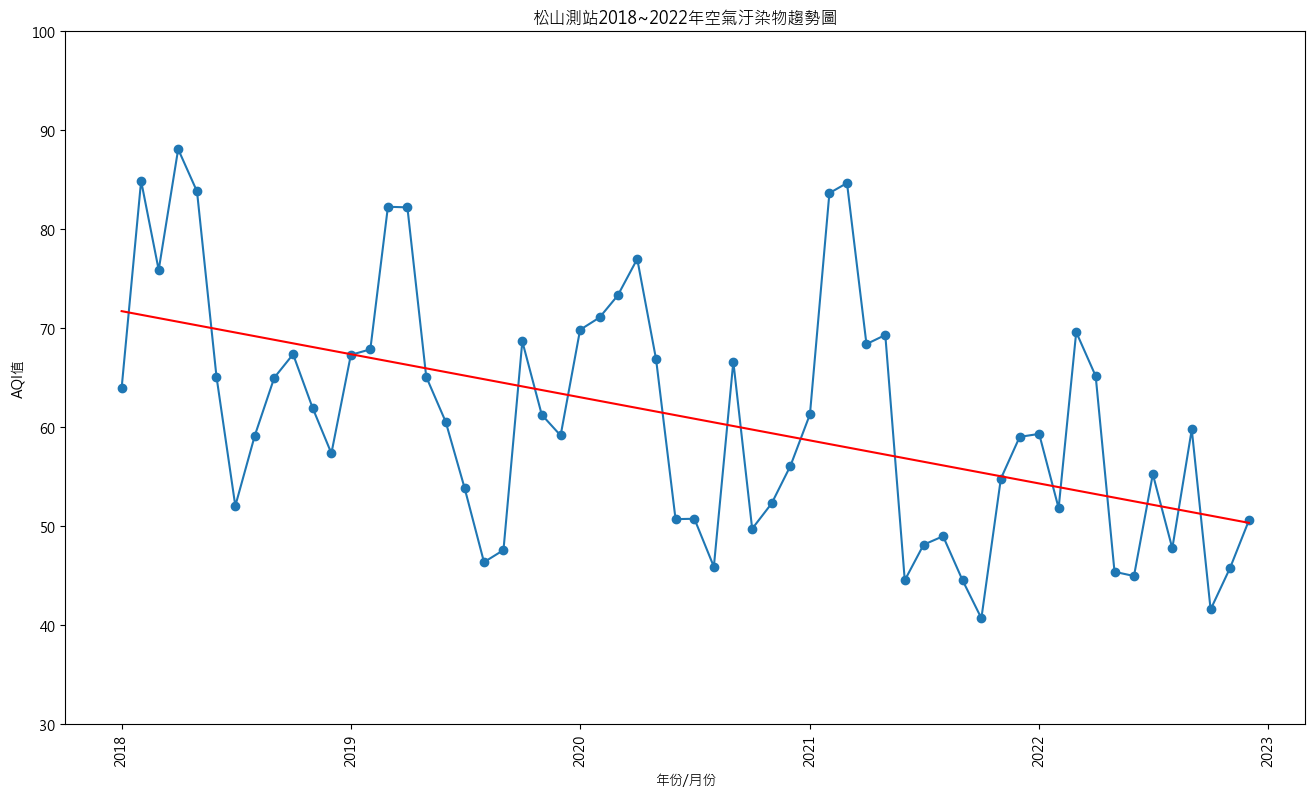

[63.97972350230416, 84.89744897959183, 75.8979416282642, 88.09700000000001, 83.8322119815668, 65.12787301587302, 52.068156682027656, 59.16158218125959, 65.01179365079365, 67.38242703533027, 61.98096825396826, 57.37436251920124, 67.32228878648233, 67.87925170068027, 82.28118279569892, 82.22033333333333, 65.10760368663595, 60.560777777777794, 53.896190476190476, 46.3826728110599, 47.6014761904762, 68.69015360983103, 61.27001587301587, 59.177096774193544, 69.85245775729648, 71.09724137931035, 73.32353302611367, 77.00750793650795, 66.87600614439324, 50.72952380952381, 50.765468509984636, 45.918448540706606, 66.63722222222222, 49.75566820276498, 52.3115238095238, 56.11628264208909, 61.31222734254993, 83.66193877551017, 84.67709677419356, 68.41126984126984, 69.32978494623656, 44.551174603174594, 48.1447311827957, 49.00244239631337, 44.553158730158735, 40.71394777265745, 54.814603174603164, 59.038387096774194, 59.33866359447005, 51.83913265306121, 69.62192012288784, 65.17755555555556, 45.4105

In [345]:
Songshan_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Songshan_AQI_By_Year.keys():
    if [key8][0:7] not in list(Songshan_month_trend.keys()):
        Songshan_month_trend[key8[0:7]] = [0,0]
for key9 in Songshan_month_trend.keys():
    for key8 in Songshan_AQI_By_Year.keys():
        if key8[0:7] == key9:
            Songshan_month_trend[key8[0:7]][0] += Songshan_AQI_By_Year[key8][1]
            Songshan_month_trend[key8[0:7]][1] += 1
for key10 in Songshan_month_trend.keys():  
    Songshan_month_trend[key10] = Songshan_month_trend[key10][0]/Songshan_month_trend[key10][1]        
Songshan_month_trend
oo_list = []
for oo in Songshan_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))
tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('松山測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

43.59815668202764
50.22356912442396
61.959343317972355
69.383
97.97193877551021
61.72379793131195


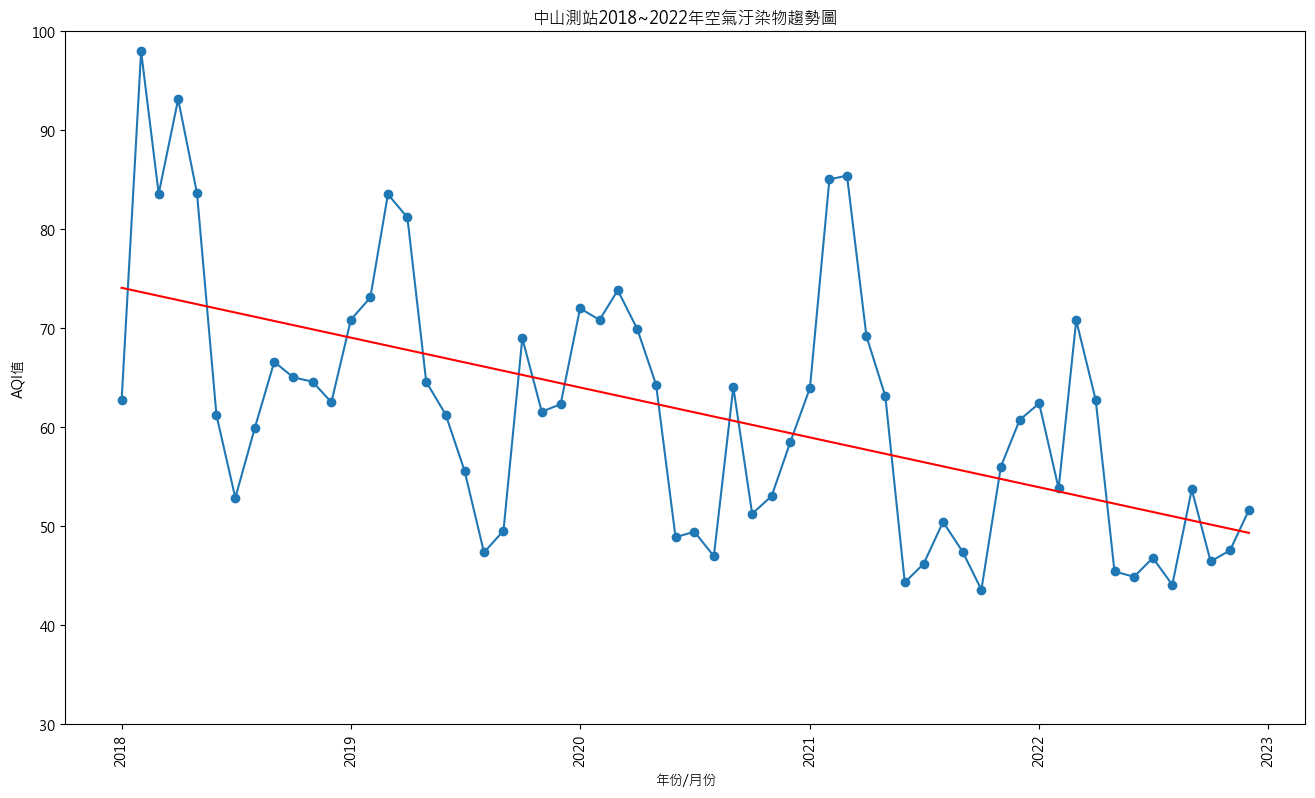

[62.78, 97.97193877551021, 83.60150537634408, 93.13971428571428, 83.63870967741936, 61.2270634920635, 52.88053763440861, 59.93064516129033, 66.61726984126985, 65.06261136712749, 64.60742857142856, 62.53622119815669, 70.86774193548388, 73.11605442176871, 83.54242703533028, 81.19780952380951, 64.6005529953917, 61.29026984126983, 55.61565284178186, 47.36267281105991, 49.554, 69.00299539170508, 61.5797619047619, 62.3389247311828, 72.0173732718894, 70.85272577996714, 73.84370199692782, 69.93338095238096, 64.31076804915513, 48.90566666666667, 49.4578494623656, 46.984685099846395, 64.06450793650794, 51.27012288786483, 53.06096825396825, 58.551505376344075, 63.97233486943165, 85.04268707482994, 85.432534562212, 69.19953968253968, 63.16215053763442, 44.34184126984126, 46.20847926267281, 50.44675883256528, 47.454, 43.59815668202764, 56.021095238095235, 60.75669738863287, 62.42079877112135, 53.82806122448981, 70.8053456221198, 62.77390476190477, 45.44239631336406, 44.90249206349207, 46.8141013824

In [346]:
Zhongshan_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Zhongshan_AQI_By_Year.keys():
    if [key8][0:7] not in list(Zhongshan_month_trend.keys()):
        Zhongshan_month_trend[key8[0:7]] = [0,0]
for key9 in Zhongshan_month_trend.keys():
    for key8 in Zhongshan_AQI_By_Year.keys():
        if key8[0:7] == key9:
            Zhongshan_month_trend[key8[0:7]][0] += Zhongshan_AQI_By_Year[key8][1]
            Zhongshan_month_trend[key8[0:7]][1] += 1
for key10 in Zhongshan_month_trend.keys():  
    Zhongshan_month_trend[key10] = Zhongshan_month_trend[key10][0]/Zhongshan_month_trend[key10][1]        
Zhongshan_month_trend
oo_list = []
for oo in Zhongshan_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))
tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('中山測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

37.95198156682028
48.74240015360983
58.373867639528946
68.28591666666667
98.45766666666667
60.13126600056164


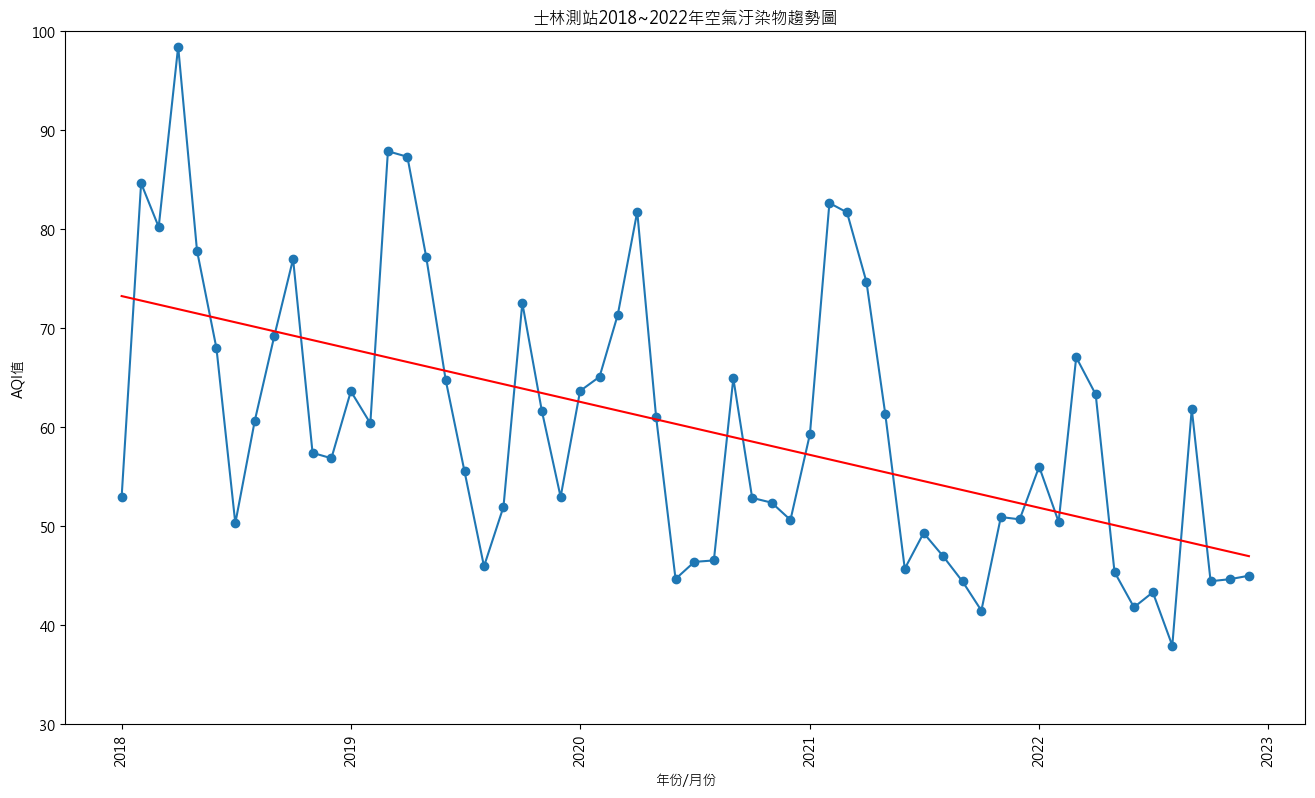

[52.98161290322581, 84.66471088435374, 80.23631336405528, 98.45766666666667, 77.85225806451614, 67.98061904761904, 50.31007680491552, 60.667726574500776, 69.20180952380952, 77.00127496159755, 57.42598412698414, 56.87728110599079, 63.64634408602152, 60.40727891156463, 87.88935483870969, 87.32966666666665, 77.19967741935486, 64.78285714285715, 55.54196620583716, 45.95743471582182, 51.97244444444444, 72.56382488479262, 61.698761904761916, 52.971290322580636, 63.675821812596006, 65.10940886699508, 71.37488479262673, 81.78171428571429, 61.08397849462366, 44.686301587301585, 46.41185867895544, 46.55589861751152, 64.9518253968254, 52.87645161290322, 52.39333333333334, 50.646543778801835, 59.32175115207375, 82.65976190476191, 81.7131797235023, 74.68566666666666, 61.32387096774193, 45.72396825396826, 49.32769585253455, 46.98651305683565, 44.42990476190476, 41.49195084485406, 50.94080952380952, 50.70827956989248, 56.03029185867895, 50.454234693877545, 67.07711213517666, 63.33361904761905, 45.386

In [347]:
Shilin_month_trend = {}
count_d_month_trend = []
time_count = 0
for key8 in Shilin_AQI_By_Year.keys():
    if [key8][0:7] not in list(Shilin_month_trend.keys()):
        Shilin_month_trend[key8[0:7]] = [0,0]
for key9 in Shilin_month_trend.keys():
    for key8 in Shilin_AQI_By_Year.keys():
        if key8[0:7] == key9:
            Shilin_month_trend[key8[0:7]][0] += Shilin_AQI_By_Year[key8][1]
            Shilin_month_trend[key8[0:7]][1] += 1
for key10 in Shilin_month_trend.keys():  
    Shilin_month_trend[key10] = Shilin_month_trend[key10][0]/Shilin_month_trend[key10][1]        
Shilin_month_trend
oo_list = []
for oo in Shilin_month_trend.values():
    oo_list.append(oo)
print(np.min(oo_list))
print("========================")
print(np.percentile(oo_list, 25))
print("========================")
print(np.median(oo_list))
print("========================")
print(np.percentile(oo_list, 75))
print("========================")
print(np.max(oo_list))
print("========================")
print(np.nanmean(oo_list))
tz = pytz.timezone('Asia/Taipei')
time_data = [tz.localize(datetime.strptime(date, '%Y/%m')) for date in list(daton_month_trend.keys())]

plt.figure(figsize=(16, 9))
plt.plot(time_data,oo_list,marker="o")
fit = np.polyfit(mdates.date2num(time_data), oo_list, 1)
trendline = np.poly1d(fit)
plt.plot(time_data, trendline(mdates.date2num(time_data)), color='red', label='趨勢線')
plt.title('士林測站2018~2022年空氣汙染物趨勢圖')
plt.xlabel('年份/月份')
plt.xticks(rotation='vertical')
plt.ylim(30, 100)
plt.ylabel('AQI值')
plt.show()
print(oo_list)

In [221]:
daton_month_trend.values()

dict_values([68.17221198156683, 93.36709183673467, 85.75566820276497, 94.67028571428573, 78.44073732718894, 66.31366666666666, 54.253824884792614, 62.22159754224271, 65.69461904761906, 68.93516129032257, 66.35790476190478, 64.8716129032258, 70.30838709677421, 71.7067857142857, 81.25926267281106, 77.01519047619048, 68.30972350230417, 64.82557142857142, 58.92394777265745, 52.7094777265745, 56.300777777777775, 75.77483870967744, 68.37946031746031, 68.15433179723503, 76.96709677419355, 76.38137931034483, 74.9990741516548, 72.988, 68.49345622119817, 56.865809523809524, 56.885176651305684, 52.60032258064515, 66.28087301587303, 59.769554531490016, 65.25901587301585, 67.91230414746545, 71.57603686635946, 88.34923469387753, 89.08672811059907, 71.47973015873013, 64.87701996927802, 48.87620634920635, 47.31043010752689, 57.85803379416281, 55.79731746031745, 54.96572964669739, 62.19442857142857, 67.54539170506912, 67.62884792626728, 62.31566326530613, 78.34682027649768, 70.88219047619047, 54.401013

In [151]:
r5 = AQI_dict["Daton_df_SO2"]
r5 = pd.DataFrame.from_dict(r5,orient="index").T

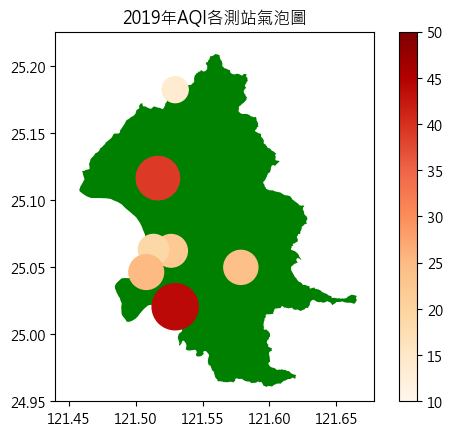

In [636]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
lon = [25.116660,25.062360,25.020610,25.050000,25.063300,25.046500,25.182720]
lat = [121.516660,121.526520,121.529550,121.578610,121.513410,121.507970,121.529580]
Tpe = {"lon":lon,"lat":lat}
base_map = gpd.read_file(r'C:\Users\Kevin\Desktop\Mypython\Final_Project\台北.shp')
My_geometry = gpd.points_from_xy(lat,lon)
tpe_points= gpd.GeoDataFrame([39,22,44,24,19,25,14],crs="epsg:4326",geometry=My_geometry)
tpe_points = tpe_points.to_crs(epsg=4326)
tpe_points.rename(columns={0:'AQI'},inplace=True)
base = base_map.plot(alpha=1,color='green',edgecolor='white')
ax = tpe_points.plot(ax=base,column="AQI",cmap='OrRd',markersize=tpe_points["AQI"]*25,legend=True,vmin=10,vmax=50,aspect=1)
ax.set_xlim([121.44, 121.678])
ax.set_ylim([24.95, 25.226])
plt.title("2019年AQI各測站氣泡圖")
plt.show()

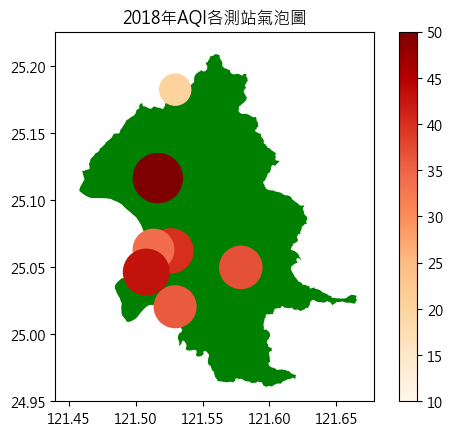

In [634]:
lon = [25.116660,25.062360,25.020610,25.050000,25.063300,25.046500,25.182720]
lat = [121.516660,121.526520,121.529550,121.578610,121.513410,121.507970,121.529580]
Tpe = {"lon":lon,"lat":lat}
base_map = gpd.read_file(r'C:\Users\Kevin\Desktop\Mypython\Final_Project\台北.shp')
My_geometry = gpd.points_from_xy(lat,lon)
tpe_points= gpd.GeoDataFrame([50,40,36,37,34,43,20],crs="epsg:4326",geometry=My_geometry)
tpe_points = tpe_points.to_crs(epsg=4326)
tpe_points.rename(columns={0:'AQI'},inplace=True)
base = base_map.plot(alpha=1,color='green',edgecolor='white')
ax = tpe_points.plot(ax=base,column="AQI",cmap='OrRd',markersize=tpe_points["AQI"]*25,legend=True,vmin=10,vmax=50,aspect=1)
ax.set_xlim([121.44, 121.678])
ax.set_ylim([24.95, 25.226])
plt.title("2018年AQI各測站氣泡圖")
plt.show()

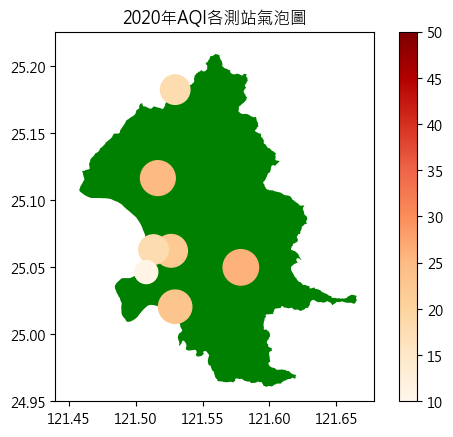

In [637]:
lon = [25.116660,25.062360,25.020610,25.050000,25.063300,25.046500,25.182720]
lat = [121.516660,121.526520,121.529550,121.578610,121.513410,121.507970,121.529580]
Tpe = {"lon":lon,"lat":lat}
base_map = gpd.read_file(r'C:\Users\Kevin\Desktop\Mypython\Final_Project\台北.shp')
My_geometry = gpd.points_from_xy(lat,lon)
tpe_points= gpd.GeoDataFrame([25,22,23,26,18,11,18],crs="epsg:4326",geometry=My_geometry)
tpe_points = tpe_points.to_crs(epsg=4326)
tpe_points.rename(columns={0:'AQI'},inplace=True)
base = base_map.plot(alpha=1,color='green',edgecolor='white')
ax = tpe_points.plot(ax=base,column="AQI",cmap='OrRd',markersize=tpe_points["AQI"]*25,legend=True,vmin=10,vmax=50,aspect=1)
ax.set_xlim([121.44, 121.678])
ax.set_ylim([24.95, 25.226])
plt.title("2020年AQI各測站氣泡圖")
plt.show()

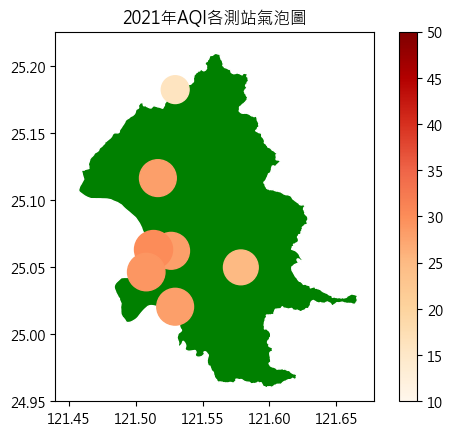

In [639]:
lon = [25.116660,25.062360,25.020610,25.050000,25.063300,25.046500,25.182720]
lat = [121.516660,121.526520,121.529550,121.578610,121.513410,121.507970,121.529580]
Tpe = {"lon":lon,"lat":lat}
base_map = gpd.read_file(r'C:\Users\Kevin\Desktop\Mypython\Final_Project\台北.shp')
My_geometry = gpd.points_from_xy(lat,lon)
tpe_points= gpd.GeoDataFrame([28,28,28,25,30,29,16],crs="epsg:4326",geometry=My_geometry)
tpe_points = tpe_points.to_crs(epsg=4326)
tpe_points.rename(columns={0:'AQI'},inplace=True)
base = base_map.plot(alpha=1,color='green',edgecolor='white')
ax = tpe_points.plot(ax=base,column="AQI",cmap='OrRd',markersize=tpe_points["AQI"]*25,legend=True,vmin=10,vmax=50,aspect=1)
ax.set_xlim([121.44, 121.678])
ax.set_ylim([24.95, 25.226])
plt.title("2021年AQI各測站氣泡圖")
plt.show()

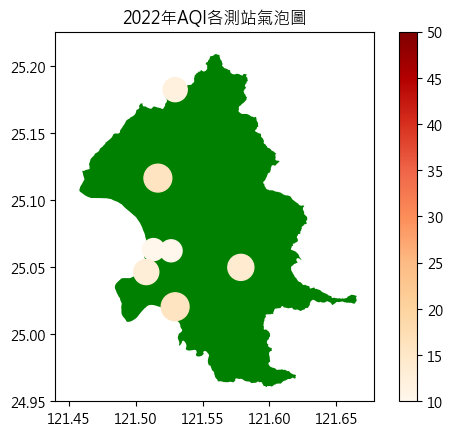

In [640]:
lon = [25.116660,25.062360,25.020610,25.050000,25.063300,25.046500,25.182720]
lat = [121.516660,121.526520,121.529550,121.578610,121.513410,121.507970,121.529580]
Tpe = {"lon":lon,"lat":lat}
base_map = gpd.read_file(r'C:\Users\Kevin\Desktop\Mypython\Final_Project\台北.shp')
My_geometry = gpd.points_from_xy(lat,lon)
tpe_points= gpd.GeoDataFrame([16,10,16,14,10,13,12],crs="epsg:4326",geometry=My_geometry)
tpe_points = tpe_points.to_crs(epsg=4326)
tpe_points.rename(columns={0:'AQI'},inplace=True)
base = base_map.plot(alpha=1,color='green',edgecolor='white')
ax = tpe_points.plot(ax=base,column="AQI",cmap='OrRd',markersize=tpe_points["AQI"]*25,legend=True,vmin=10,vmax=50,aspect=1)
ax.set_xlim([121.44, 121.678])
ax.set_ylim([24.95, 25.226])
plt.title("2022年AQI各測站氣泡圖")
plt.show()

In [177]:
# 士林 25.116660, 121.516660
# 中山 25.062360, 121.526520
# 古亭 25.020610, 121.529550
# 松山 25.050000, 121.578610
# 大同 25.063300, 121.513410
# 萬華 25.046500, 121.507970
# 陽明 25.182720, 121.529580